# Live-coding script for OpenNeuromorphic Rockpool / Xylo demo April 2023
Dylan Muir
## Outline
 1. ``LIF`` module, spiking neuron
 4. How to compose a network
    - `Linear` weights
    - `Sequential` combinator
    - `Residual` combinator
 5. Audio task
    - Introduce SHD
 6. Network architecture
 7. Training
 8. Xylo architecture
 9. Mapping, quantization, deployment
 10. Inference using ``XyloSim``
 11. Inference on Xylo HDK


This live-coding script demonstrates working with Rockpool to train SNN networks for Xylo, on an audio task.

First we need to install the required packages.

In [1]:
# - Install requirements for this notebook
%pip install --quiet rockpool matplotlib torch tonic rich tqdm jax jaxlib xylosim samna bitstruct

# - Import and configure matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["figure.dpi"] = 300

# - Nice printing
from rich import print

# - Torch and numpy
import torch
import numpy as np

# - For displaying images
from IPython.display import Image


Note: you may need to restart the kernel to use updated packages.


Rockpool is a deep learning library for SNNs, designed to make it very easy to design, train and deploy applications to neuromorphic hardware.

Documentation: https://rockpool.ai

In [2]:
# - The LIF module is a Leaky Integrate and Fire spiking neuron
from rockpool.nn.modules import LIF

In [3]:
# - Create a single LIF neuron to examine
lif = LIF(1, threshold=10.)
print(lif)

LIF  with shape (1, 1)

In [4]:
# - Generate some Poissonian spiking input to the neuron
f = 0.02
T = 500
Nin = 1
input_sp = np.random.rand(T, Nin) < f

# - Evolve the neuron by passing the data through
#   `record = True` records and returns internal state
out, _, rec_dict = lif(input_sp, record = True)

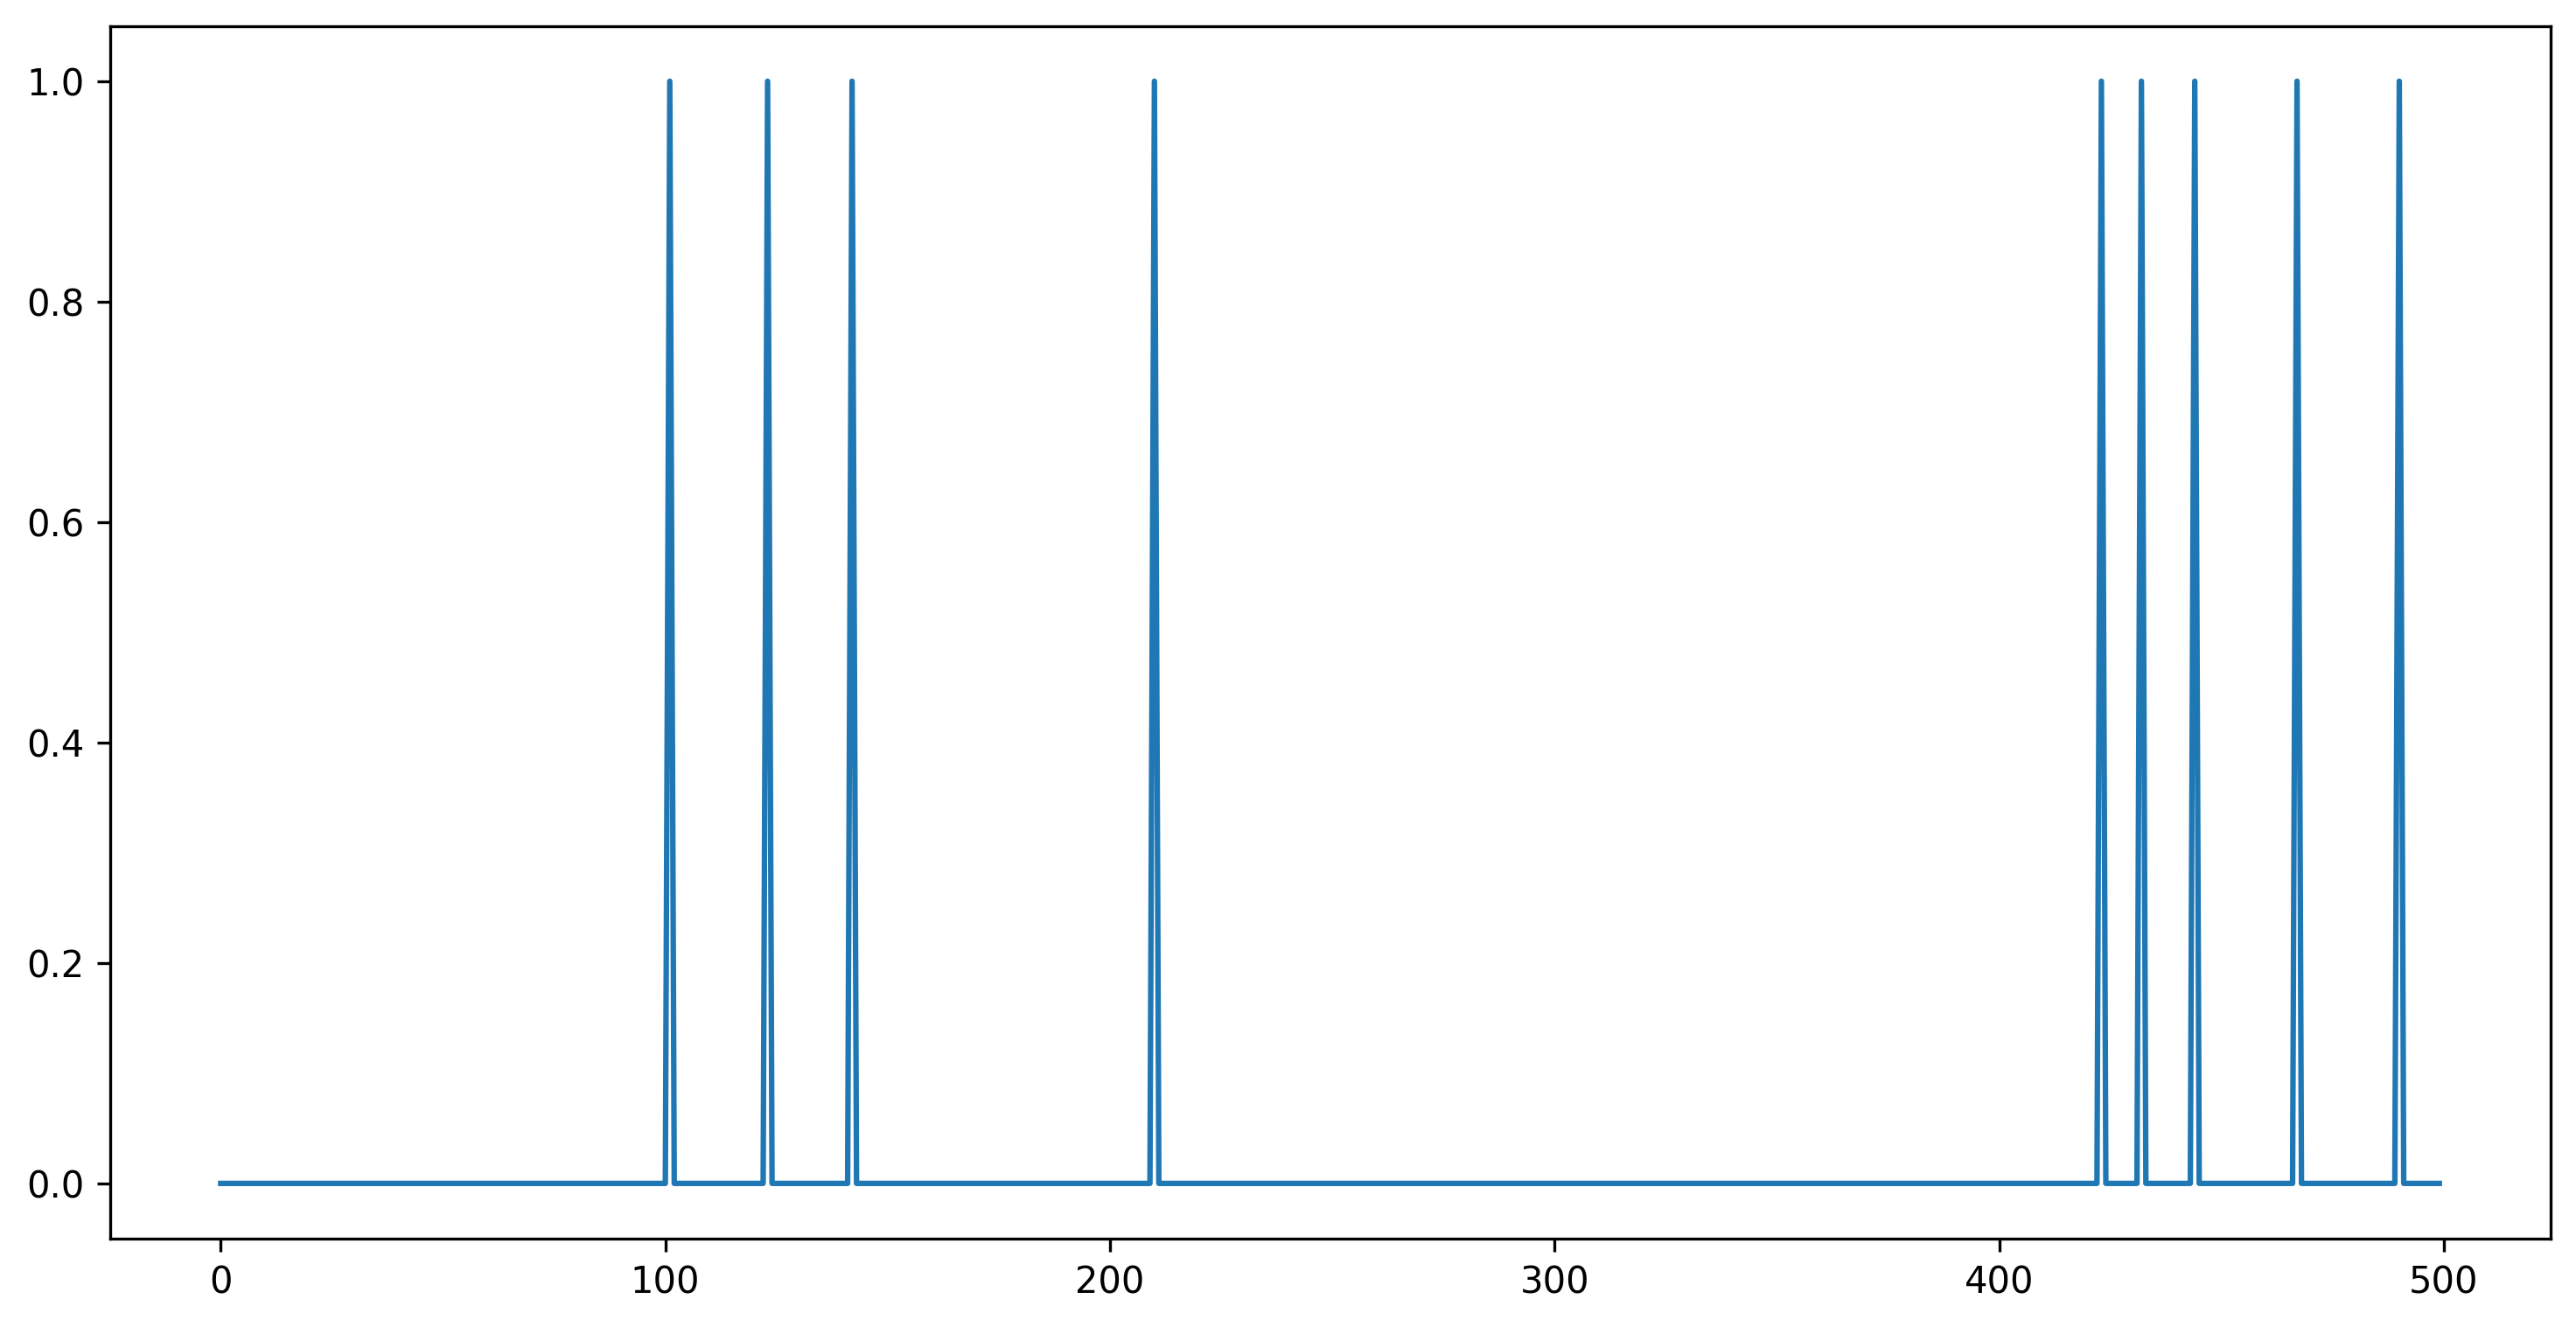

In [5]:
# - plot the output events
plt.plot(out.squeeze())

In [ ]:
# - Let's look at the recorded state. What did we get back from the evolution?
rec_dict.keys()

dict_keys(['irec', 'spikes', 'isyn', 'vmem', 'U'])

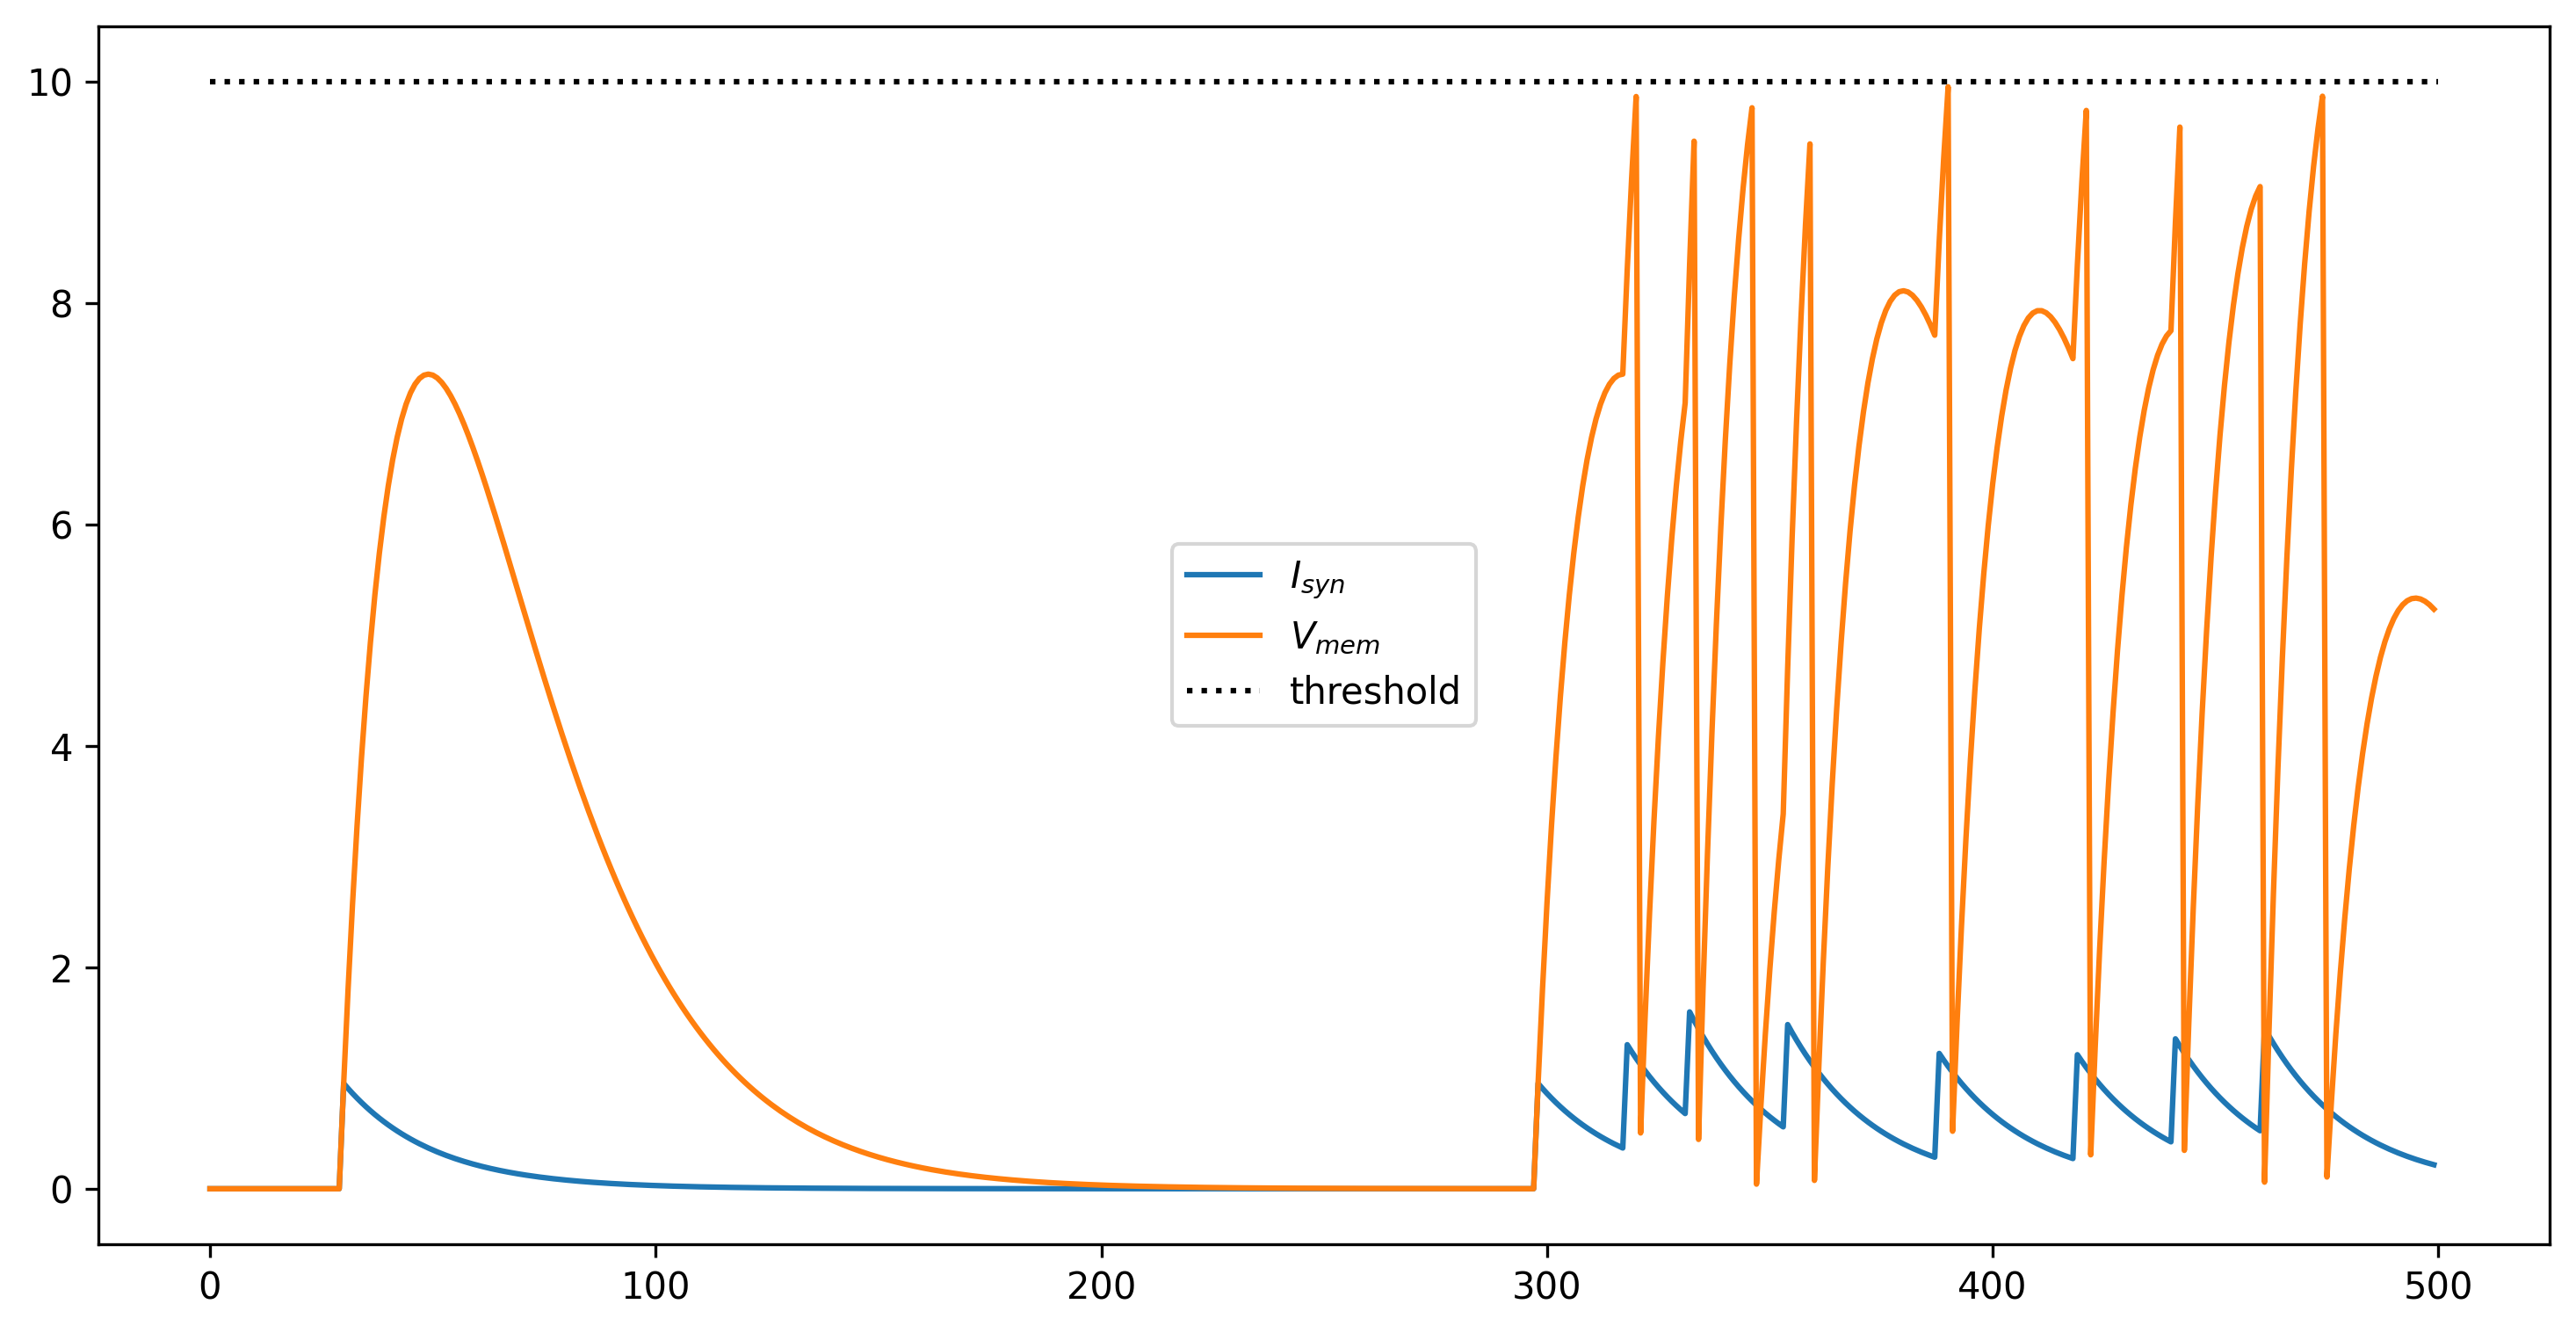

In [ ]:
# - Let's plot the synaptic current `isyn` and membrane potential `vmem`
plt.plot(rec_dict['isyn'].squeeze(), label='$I_{syn}$')
plt.plot(rec_dict['vmem'].squeeze(), label='$V_{mem}$')
plt.plot([0, 500], [10, 10], 'k:', label='threshold')
plt.legend()

In [ ]:
# - Rockpool modules all have a `state()` method which returns the internal module state
print(lif.state())

{'spikes': array([0.]), 'isyn': array([[0.21678717]]), 'vmem': array([5.23487272])}

In [ ]:
# - Rockpool modules all have a `parameters()` method which returns the trainable parameters of a module
print(lif.parameters())

{'tau_mem': array([0.02]), 'tau_syn': array([[0.02]]), 'bias': array([0.]), 'threshold': array(10.)}

In [ ]:
# - Rockpool modules all have a `simulation_parameters()` method which returns the non-trainable parameters
print(lif.simulation_parameters())

{'dt': 0.001, 'noise_std': 0.0, 'max_spikes_per_dt': 65536.0}

Obviously a single LIF neuron is not particularly useful. We need to be able to compose arbitrary network architectures. Now let's see how to build up a network in Rockpool.

We'll use a simple feed-forward network architecture here.

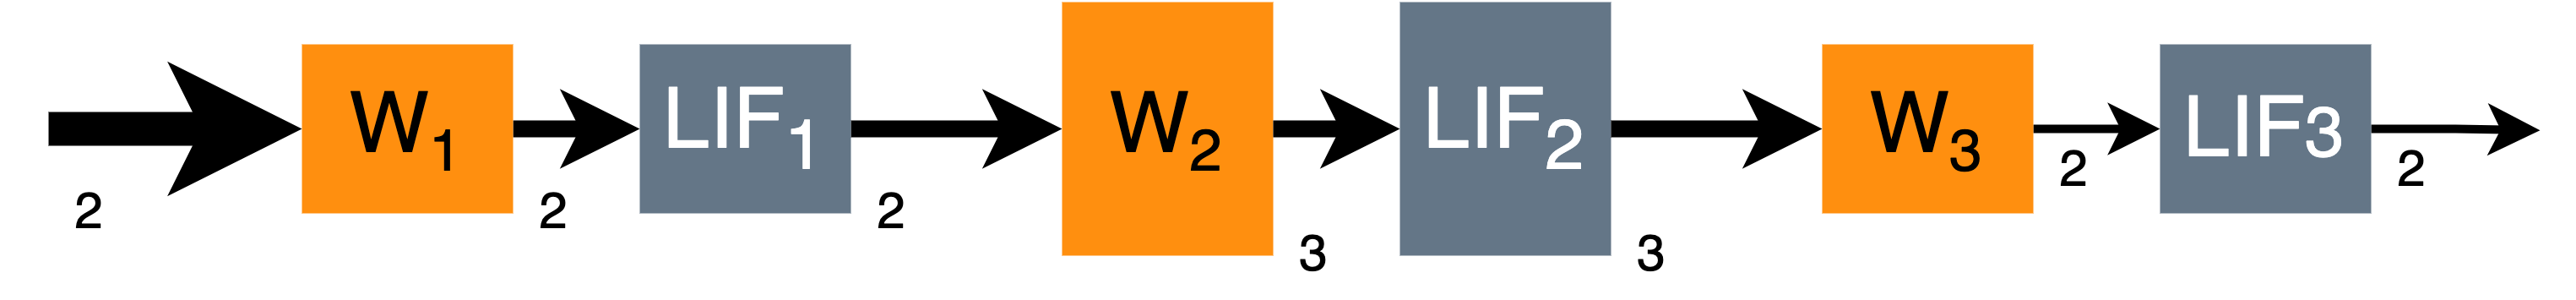

In [ ]:
Image('images/network-layout-small.png')

In [ ]:
# -  Import the required modules. `Linear` is a set of linear weights
from rockpool.nn.modules import Linear, LIF

# - `Sequential` is a combinator that puts modules in a sequence
from rockpool.nn.combinators import Sequential

In [ ]:
# - We simply specify the modules in a sequence
net = Sequential(
    Linear((2, 3)),
    LIF(3),
    
    Linear((3, 3)),
    LIF(3),

    Linear((3, 2)),
    LIF(2),
)

print(net)

ModSequential  with shape (2, 2) {
    Linear '0_Linear' with shape (2, 3)
    LIF '1_LIF' with shape (3, 3)
    Linear '2_Linear' with shape (3, 3)
    LIF '3_LIF' with shape (3, 3)
    Linear '4_Linear' with shape (3, 2)
    LIF '5_LIF' with shape (2, 2)
}

In [ ]:
# - The network itself is a module, with parameters, state, etc.
print(net.parameters())

{
    '0_Linear': {
        'weight': array([[-0.63237275, -0.09437447, -0.49732004],
       [ 0.74732841,  0.20283192,  1.20100709]])
    },
    '1_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '2_Linear': {
        'weight': array([[-0.83951025, -0.70556249,  0.62122044],
       [ 0.96950654,  0.92754045, -0.1890062 ],
       [-0.65216892, -0.03649732, -0.4104885 ]])
    },
    '3_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '4_Linear': {
        'weight': array([[-0.00986733, -1.39601562],
       [ 0.595371  , -0.00647402],
       [-0.72222901, -0.84685622]])
    },
    '5_LIF': {
        'tau_mem': array([0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02]]),
        'bias': array([0., 0.]),
        'threshold': array([1., 1.])
    }
}

In [ ]:
print(net.state())

{
    '0_Linear': {},
    '1_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '2_Linear': {},
    '3_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '4_Linear': {},
    '5_LIF': {'spikes': array([0., 0.]), 'isyn': array([[0.],
       [0.]]), 'vmem': array([0., 0.])}
}

# BACK TO POWERPOINT for SHD intro

``tonic`` is a package for managing neuromorphic datasets (https://tonic.readthedocs.io)

We'll use tonic to download the Spiking Heidlberg Digits dataset (https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/), and provide a convenient python `torch`-like dataset.

``tonic`` also provides data transformations and caching.

In [ ]:
# - Import tonic, download and import the SHD dataset
import tonic
train_data = tonic.datasets.SHD('./data')
shd_timestep = 1e-6
shd_channels = 700
shd_classes = 20

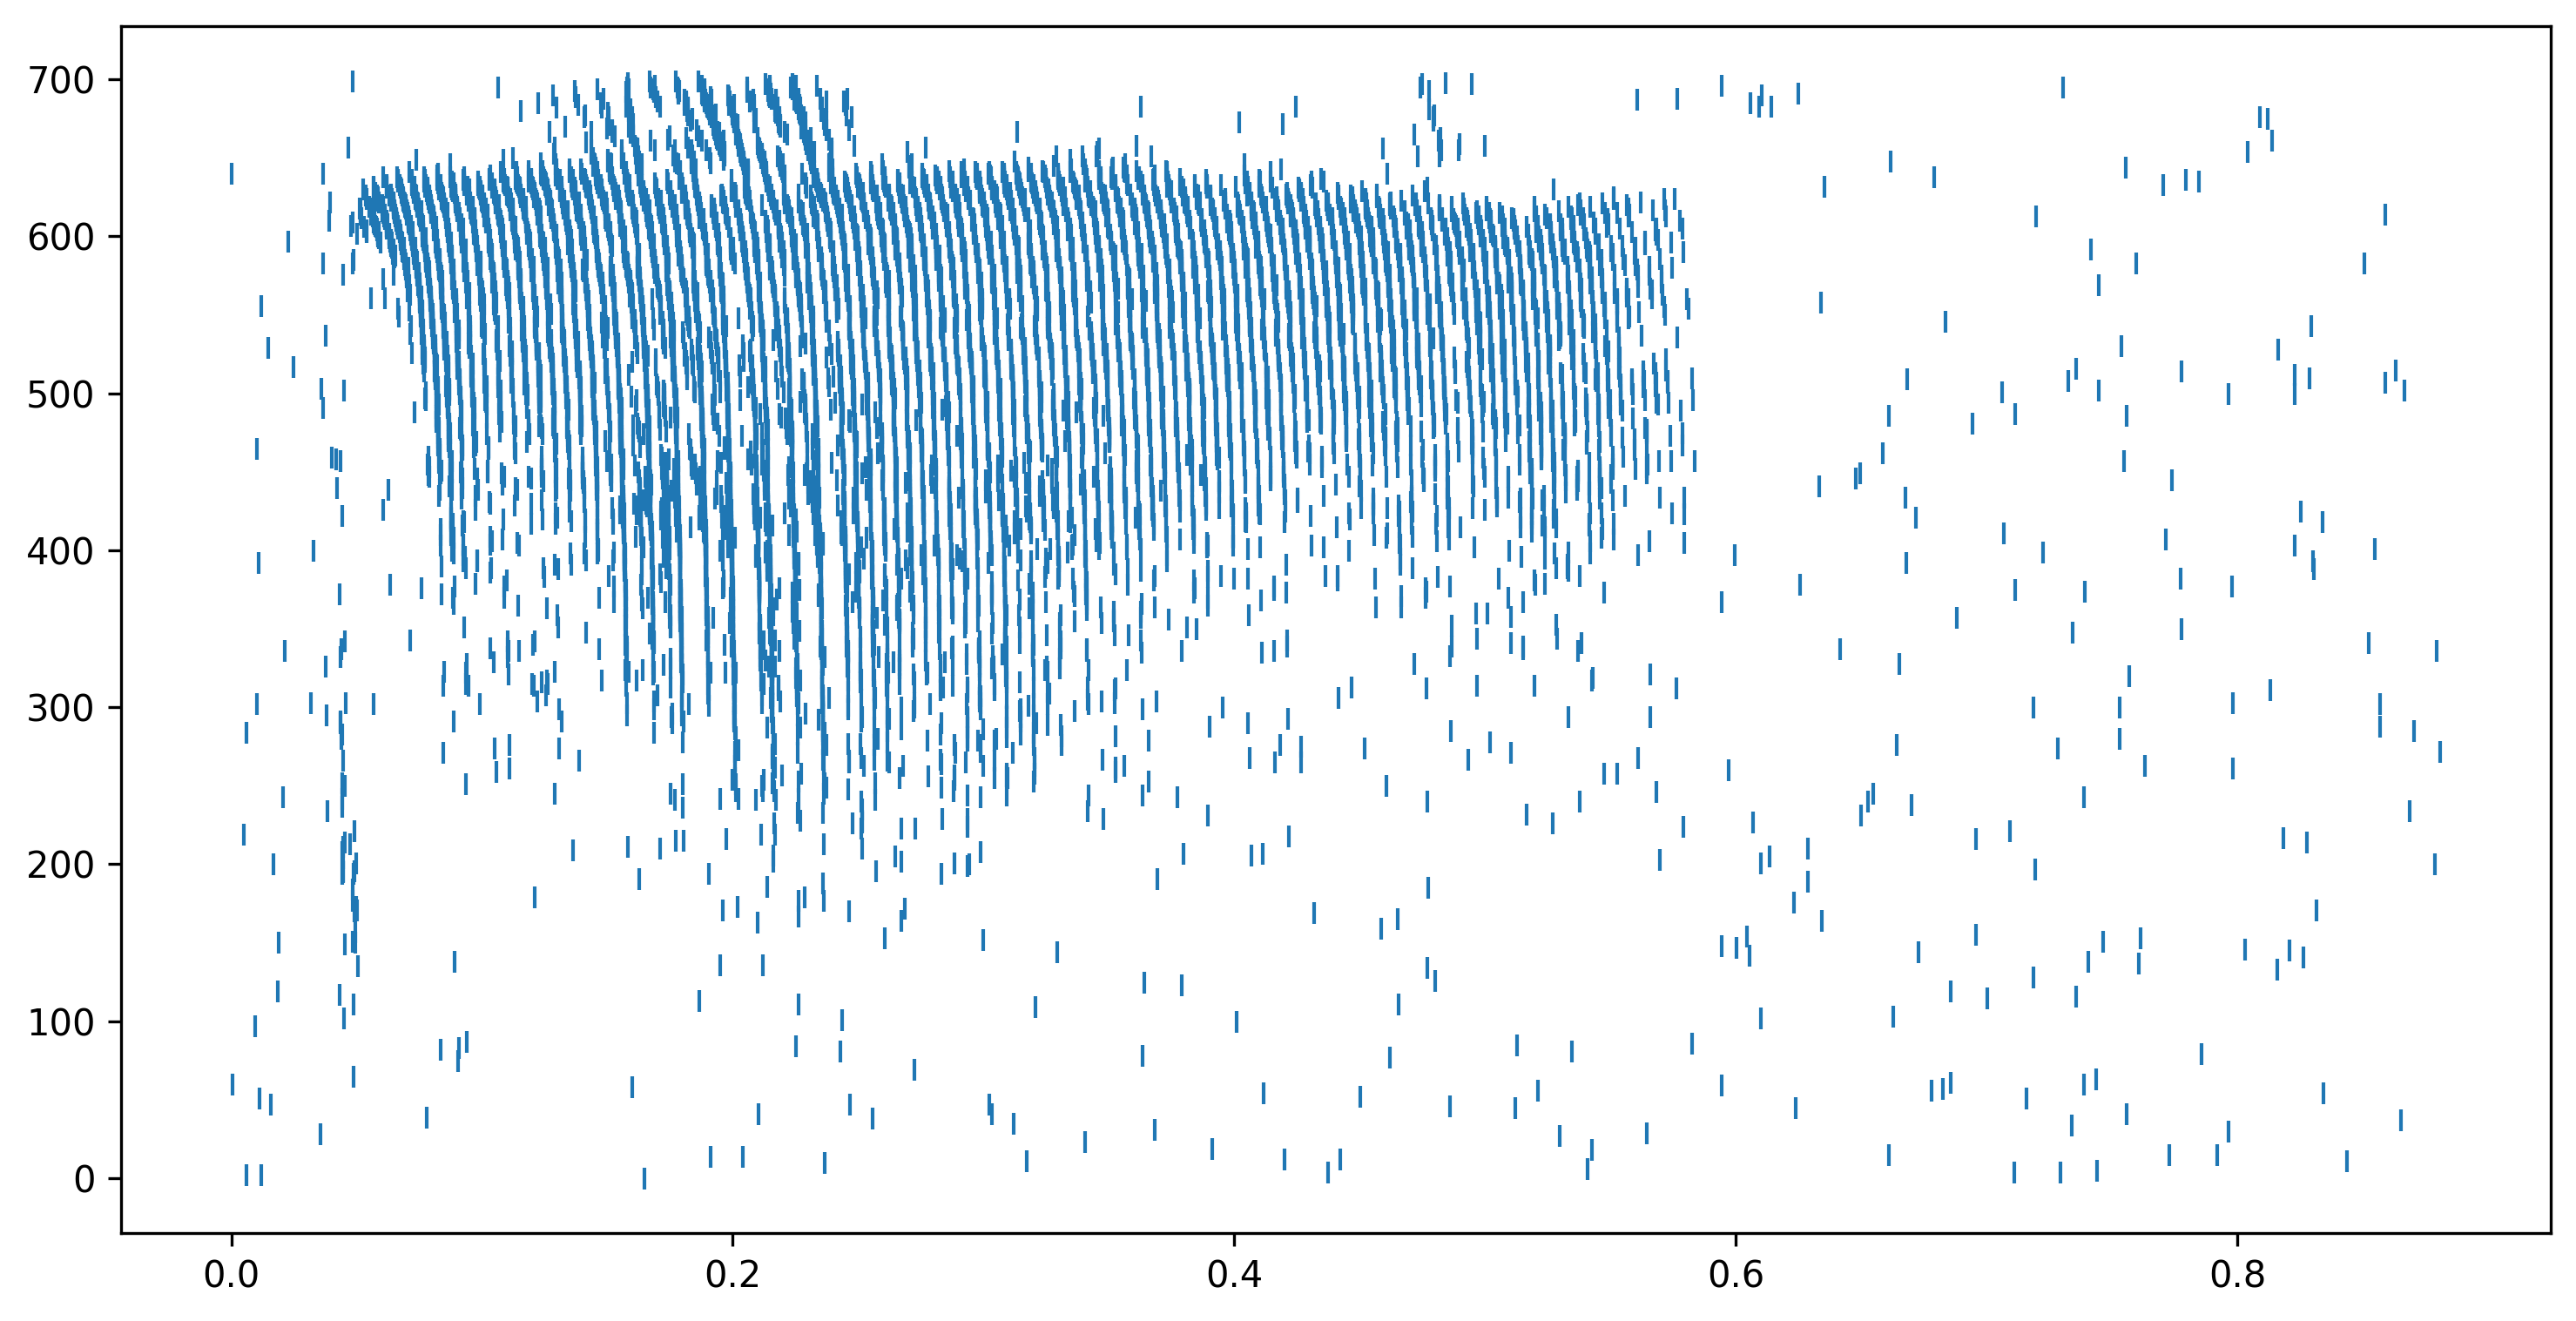

In [ ]:
# - Let's examine one sample of the dataset
events, label = train_data[1]
times = events['t'] * shd_timestep
channels = events['x']
plt.plot(times, channels, '|')

In [ ]:
# - We need to downsample the data to use it (to make the network and training simpler)
net_channels = 16
net_dt = 10e-3
sample_T = 250

In [ ]:
# - We'll use `tonic` to downsample in 

import tonic.transforms as T

transform = T.Compose([
        # - Downsample in time and space
        T.Downsample(
            time_factor=shd_timestep / net_dt,
            spatial_factor=net_channels / shd_channels
            ),

        # - Rasterise the events
        T.ToFrame(
            sensor_size=(net_channels, 1, 1), time_window=1
        ),
        
        # - Convert to a tensor
        torch.Tensor,

        # - Make sure the samples are not too long in time
        lambda m: torch.squeeze(m)[:sample_T, :],
        ])

In [ ]:
# - Reload the dataset with these transformations
train_data = tonic.datasets.SHD('./data', transform=transform)

In [ ]:
# - Get one training sample
raster, label = train_data[1]

# - Extract spike times
times, channels = torch.where(raster)

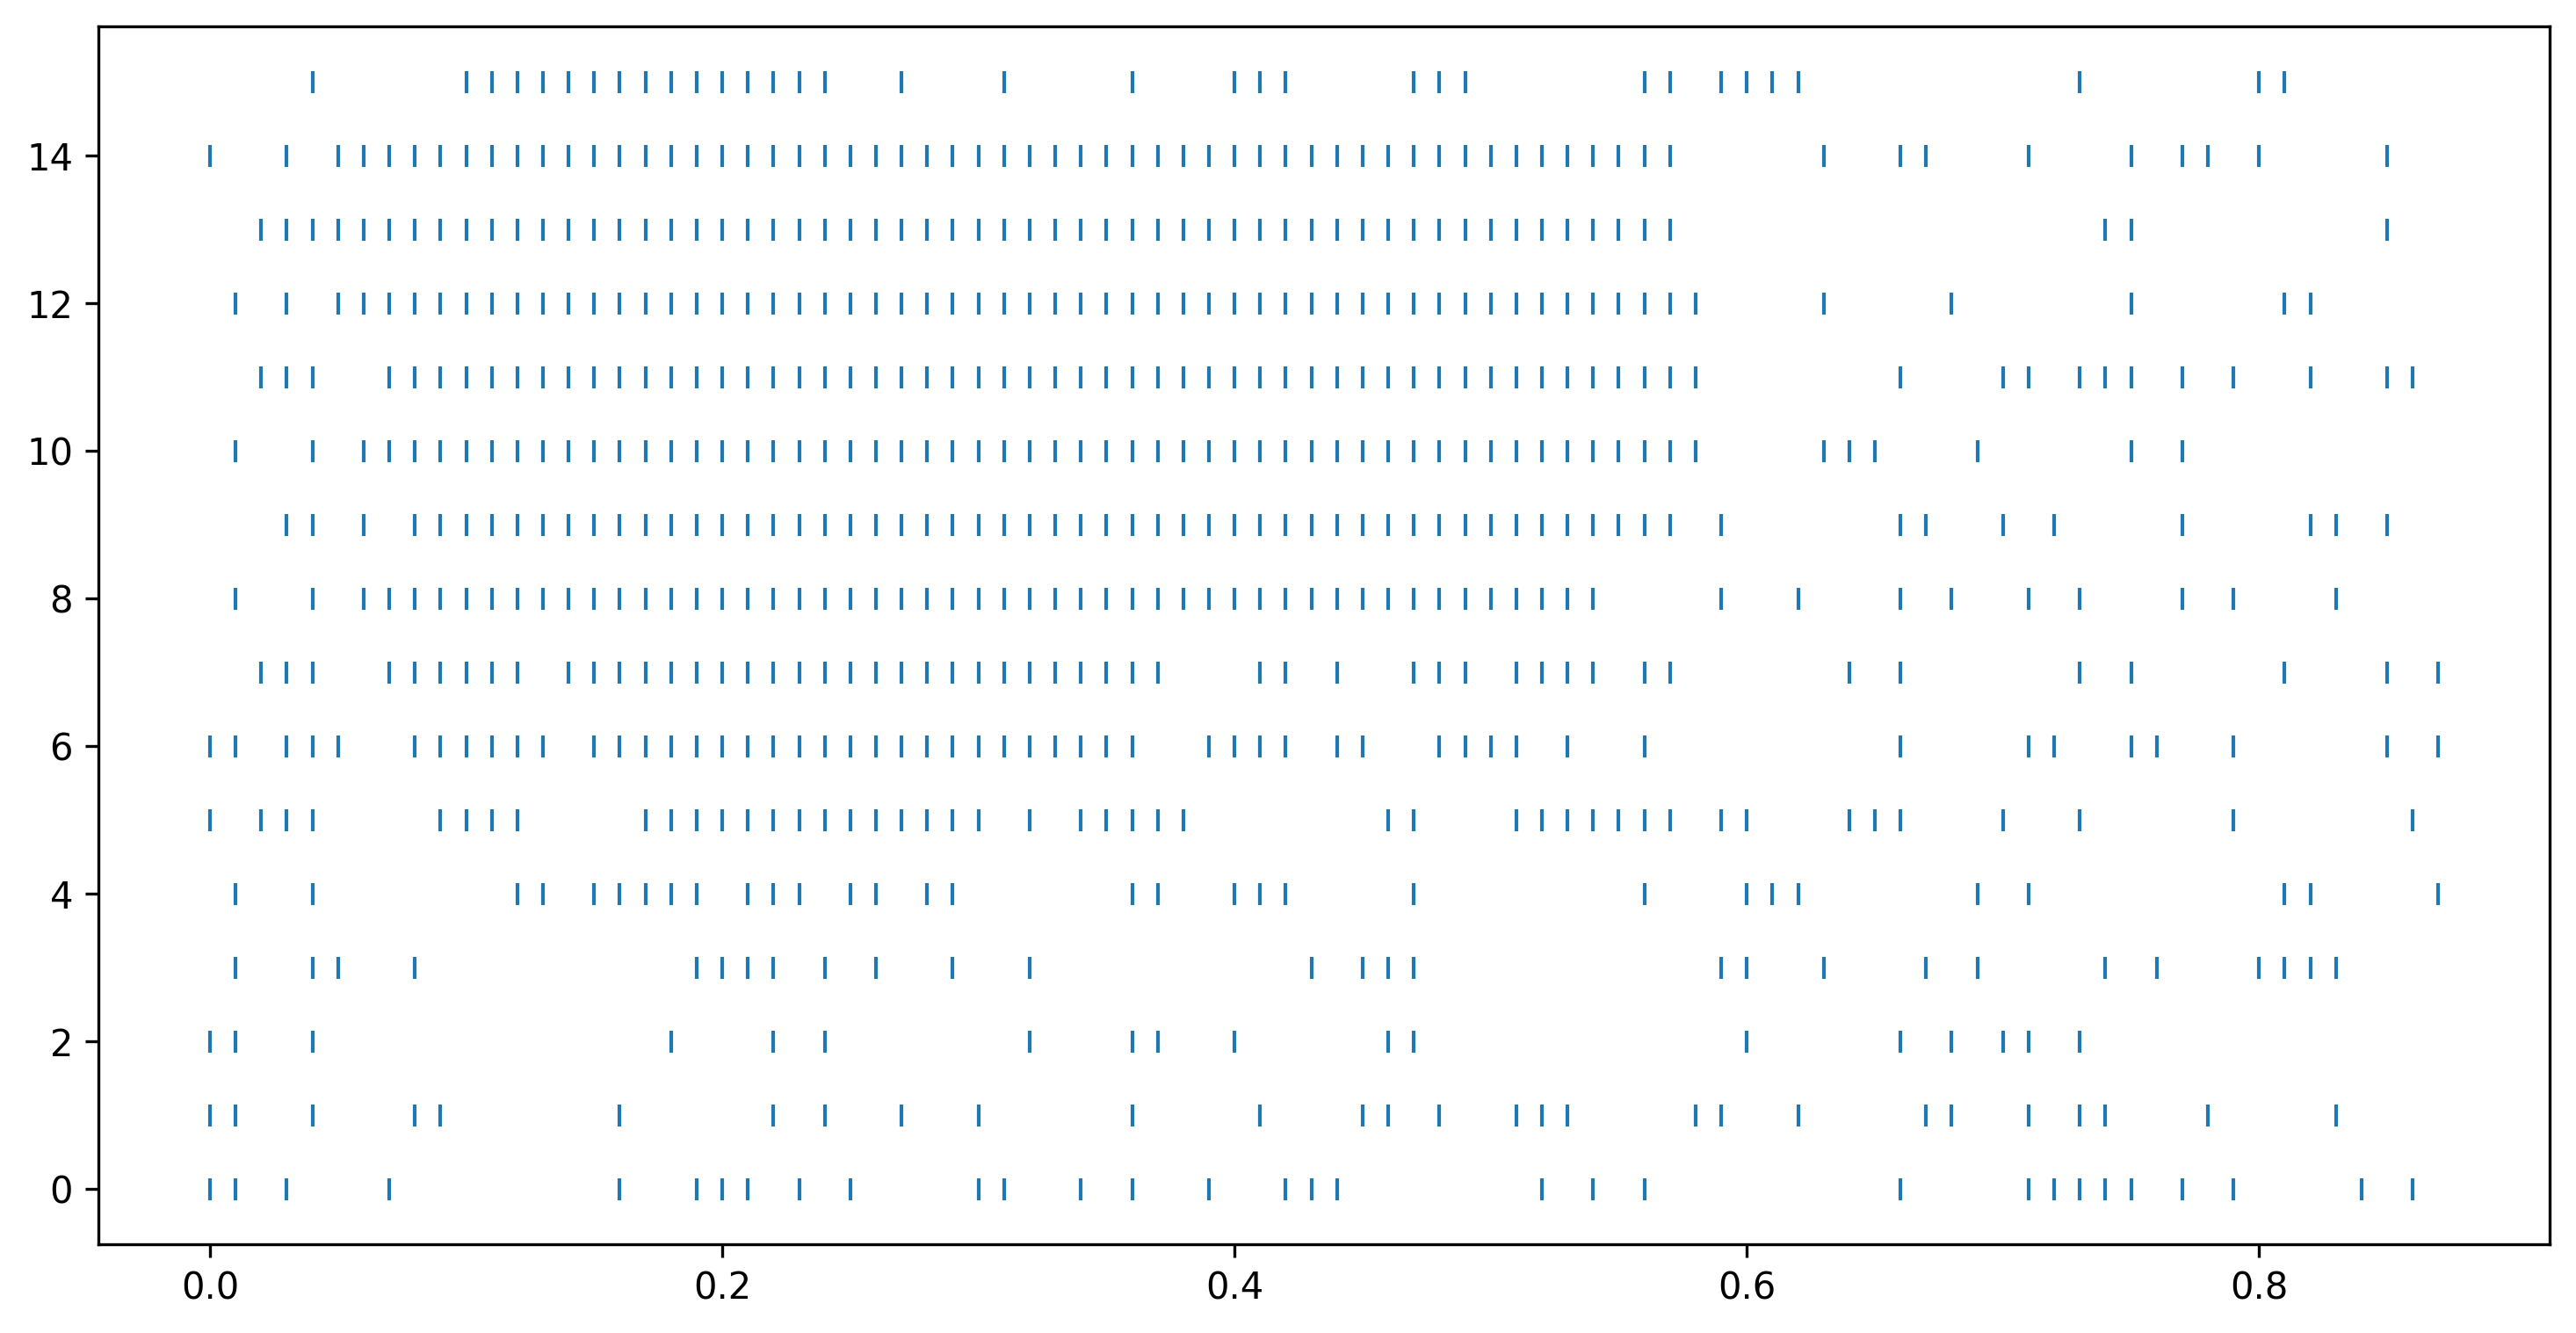

In [ ]:
# - Plot this sample
plt.plot(times * net_dt, channels, '|')

Now we create a data loader to use in training. This is a standard `torch` dtaa loader, so I'm going to gloss over this cell.

We will select only the first 8 class labels to use, since Xylo only supports 8 output channels.

We will creata a data loader, using ``tonic`` to provide disk caching of the data. In-memory caching is also supported by ``tonic``, but not used here.

In [ ]:
# - Create a class which subsets a dataset to a list of matching labels
class SubsetClasses(torch.utils.data.Dataset):
    def __init__(self,
                 dataset,
                 match_labels,
                 ):
        indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label in match_labels:
                indices.append(idx)

        self._subset_ds = torch.utils.data.Subset(dataset, indices)
        self._len = len(indices)

    def __getitem__(self, index):
        return self._subset_ds[index]
    
    def __len__(self):
        return self._len

# - Define arguments for the data loader
dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=0,
)

# - Create the data loader, using `tonic` to provide a disk cache
train_dl = torch.utils.data.DataLoader(
    tonic.DiskCachedDataset(
        dataset=SubsetClasses(train_data, range(8)),
        cache_path=f"cache/{train_data.__class__.__name__}/train/{net_channels}/{net_dt}",
        reset_cache = False,
    ),
    **dataloader_kwargs
)

Now we'll define and train an SNN for the SHD task, to deploy to Xylo. We'll use the ``torch`` backend of Rockpool, which uses the PyTorch automatic differentiation pipeline to train NNs.

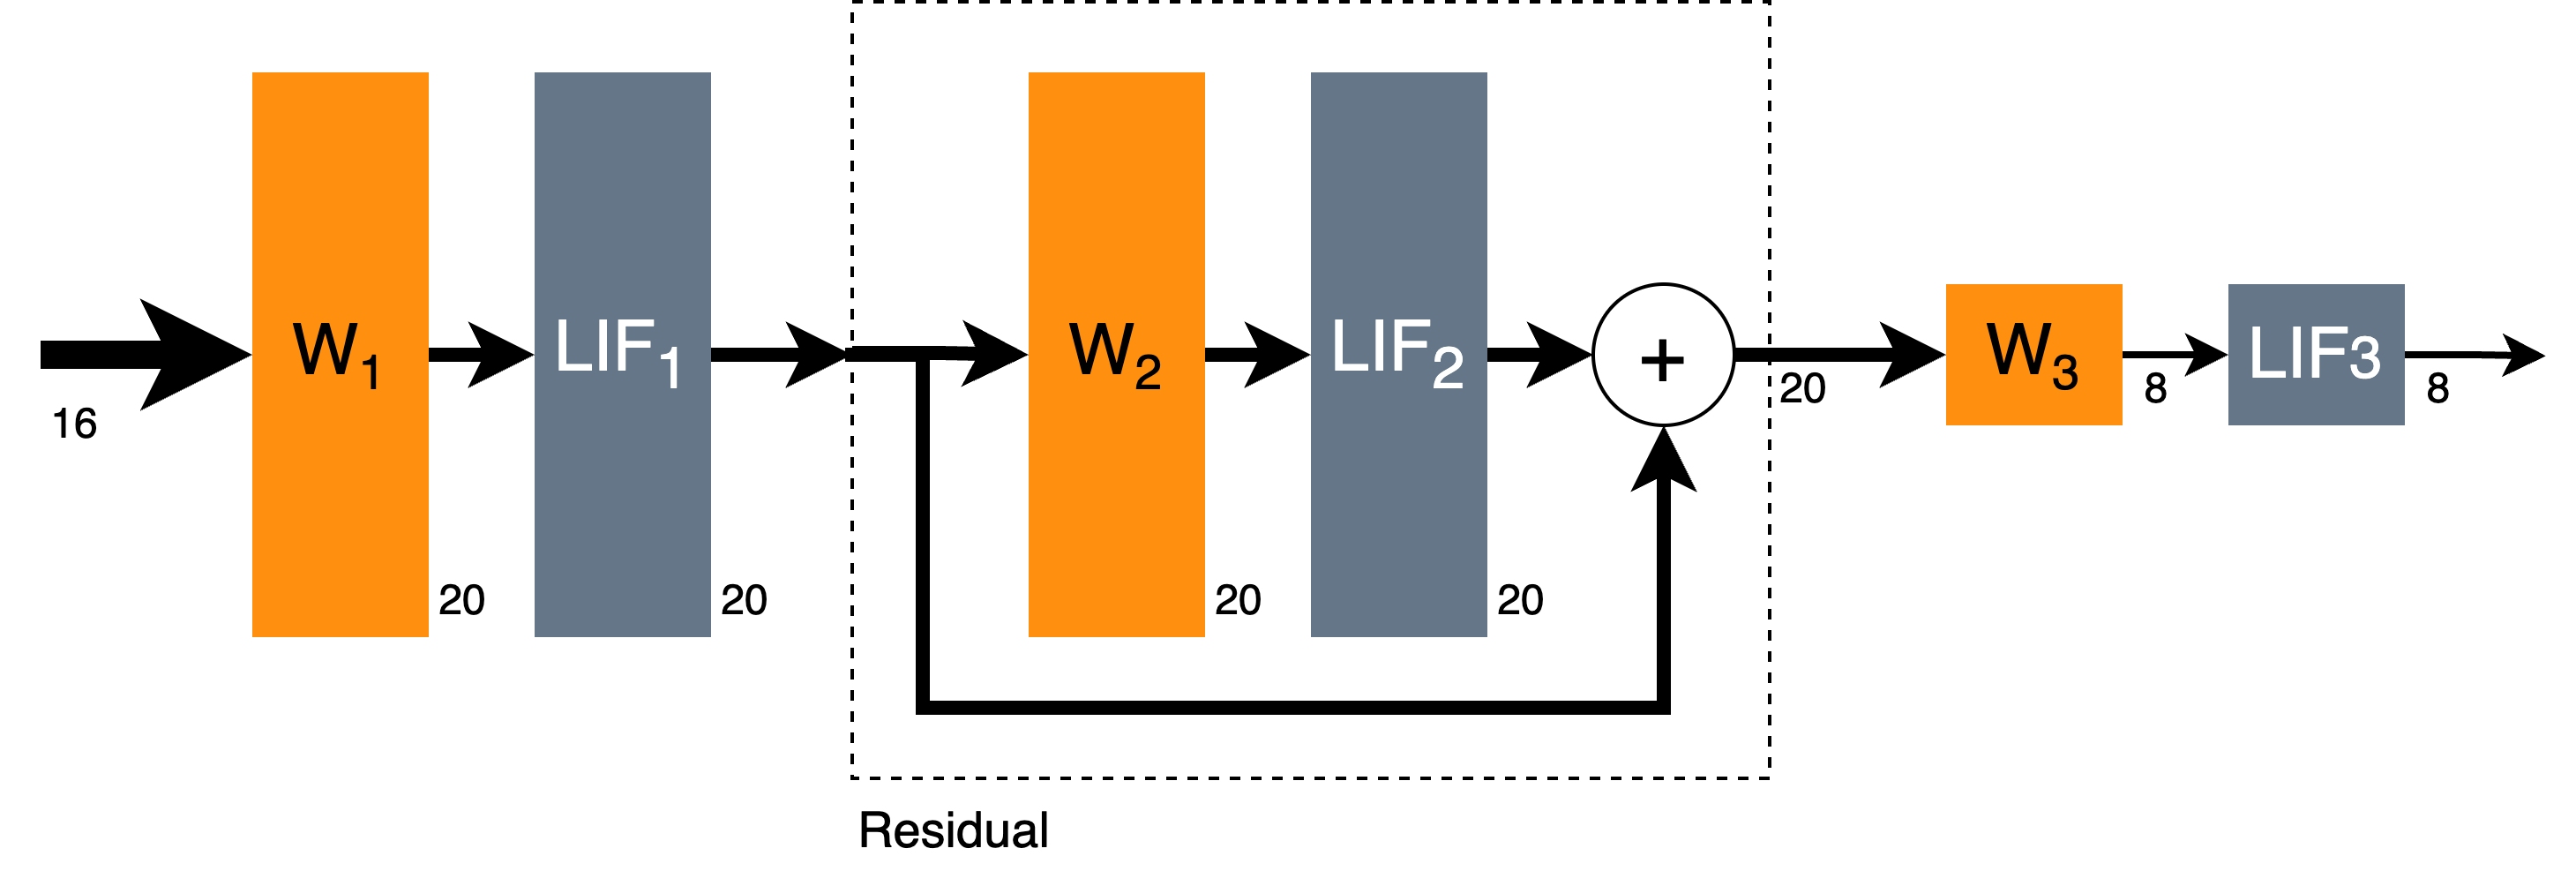

In [ ]:
# - Show an image of the target network architecture
Image('images/network-layout-shd.svg.png')

In [ ]:
# - Import the required torch-backed modules and combinators
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Define a simple network architecture
Nin = net_channels
Nhid = 20
Nembed = 8
Nout = 8

net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout),
)
print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [ ]:
# - By default all parameters are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[ 0.0320, -0.0603,  0.0695,  0.2232, -0.5472,  0.4177, -0.2023,  0.0174,
         -0.0929, -0.0081, -0.3732, -0.2485, -0.5763, -0.2460,  0.2507, -0.0053,
         -0.4152, -0.0993,  0.5406, -0.4435],
        [ 0.1382, -0.0511, -0.0830,  0.0256,  0.5164, -0.4905, -0.2989, -0.1951,
         -0.3729, -0.2293,  0.3671,  0.5374,  0.1987,  0.3035,  0.2842,  0.4630,
          0.4558,  0.3215,  0.4714,  0.5215],
        [ 0.6028,  0.5061, -0.2008, -0.2864,  0.0782,  0.0045, -0.4898, -0.0921,
         -0.3238,  0.0807, -0.5664,  0.5130,  0.3715,  0.5111,  0.3620,  0.5370,
          0.5496,  0.3328,  0.2944,  0.1270],
        [-0.2366, -0.3842, -0.5611, -0.3418,  0.0119,  0.6063,  0.3820,  0.5083,
          0.1310, -0.3676, -0.0332,  0.5900, -0.0578, -0.4950,  0.4859, -0.2775,
          0.5067, -0.1344, -0.4516,  0.4432],
        [-0.1468,  0.4303,  0.3044,  0.1125, -0.2572, -0.4718,  0.0900, -0.5772,
          0.6053,  0.2790,  0.2799,  0.1606, -0.4862,  0.5055, -0.5254,  0.2794,
         -0.2123, -0.1556,  0.0201, -0.3665],
        [ 0.4997, -0.1679, -0.2175, -0.5063, -0.4938, -0.0120,  0.2730,  0.3819,
         -0.4661,  0.2000, -0.5381, -0.0283,  0.2728, -0.2775,  0.2249,  0.0053,
          0.4499,  0.1685,  0.1943,  0.3597],
        [-0.0305,  0.0633,  0.4653,  0.1917,  0.3650,  0.5934, -0.5945, -0.0471,
          0.5479, -0.0787,  0.2663,  0.4365, -0.5628,  0.6043,  0.4466, -0.1309,
          0.2309, -0.4578,  0.3080, -0.5685],
        [ 0.4050,  0.6014,  0.2601, -0.1876, -0.4134,  0.0560, -0.0670,  0.4836,
         -0.4257,  0.4883, -0.2374,  0.4959, -0.1588,  0.0486, -0.5559, -0.5189,
          0.1169, -0.2734, -0.1574, -0.3165],
        [ 0.0037,  0.2539,  0.2945, -0.0441, -0.3448, -0.3967, -0.5216,  0.3215,
          0.5703, -0.2993, -0.5410, -0.4839, -0.5797, -0.0683, -0.5997, -0.1471,
          0.2480,  0.5832,  0.1761, -0.4322],
        [-0.6069, -0.3028, -0.5211,  0.0462,  0.2528,  0.1299, -0.1752,  0.0470,
         -0.3505, -0.3870,  0.3731, -0.1503,  0.3909, -0.4898,  0.3225,  0.4923,
          0.0050,  0.2675,  0.5785,  0.4854],
        [-0.4334,  0.4003,  0.4043, -0.4676,  0.4492, -0.1284, -0.0221, -0.2438,
          0.5981,  0.4707,  0.4326,  0.1467, -0.0221, -0.3441,  0.5314,  0.3461,
          0.3662,  0.1874,  0.3175, -0.0543],
        [-0.1806, -0.1900, -0.4383,  0.1522, -0.4851, -0.3373,  0.3620,  0.4786,
         -0.0029,  0.3106,  0.0034, -0.2737, -0.2516, -0.3900, -0.3348,  0.3094,
         -0.5796, -0.0604,  0.0885, -0.1814],
        [-0.5736,  0.1530,  0.5948, -0.3355,  0.0548, -0.3958, -0.1766, -0.6076,
          0.2020, -0.0704,  0.1450, -0.2887, -0.4644, -0.2322, -0.3698,  0.0017,
         -0.2567,  0.2884,  0.3543,  0.1745],
        [-0.1031,  0.1861,  0.3209,  0.5294,  0.3996, -0.0229, -0.3737, -0.5642,
         -0.2920,  0.4173,  0.5212, -0.4816,  0.5264, -0.0436, -0.3387, -0.0801,
          0.1524, -0.3681,  0.4862,  0.3076],
        [ 0.2214, -0.1984,  0.3263,  0.1045, -0.2788, -0.4412, -0.0576,  0.5775,
         -0.3897,  0.3075, -0.1553, -0.5002,  0.2076, -0.0782,  0.4500, -0.3267,
          0.0676,  0.2328,  0.4550, -0.3395],
        [-0.1267,  0.0833, -0.0629,  0.1406, -0.2270, -0.2807,  0.1306,  0.5798,
         -0.2214, -0.5031, -0.5581, -0.1440, -0.0280,  0.1826, -0.3683,  0.0238,
          0.2963,  0.2313,  0.1511,  0.2336]], requires_grad=True)
    },
    '1_LIFTorch': {
        'tau_mem': Parameter containing:
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200], requires_grad=True),
        'tau_syn': Parameter containing:
tensor([[0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
 

In [ ]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Import the `Constant` decorator, so we can specify non-trainable parameters
from rockpool.parameters import Constant

# - Define shared neuron parameters to use
neuron_parameters = {
    'tau_mem': Constant(50e-3),
    'tau_syn': Constant(20e-3),
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': net_dt,
}

# - Define the network with shared parameters
net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid, **neuron_parameters),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid, **neuron_parameters),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout, **neuron_parameters),
)

print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [ ]:
# - Now only weights are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[ 0.0320, -0.0603,  0.0695,  0.2232, -0.5472,  0.4177, -0.2023,  0.0174,
         -0.0929, -0.0081, -0.3732, -0.2485, -0.5763, -0.2460,  0.2507, -0.0053,
         -0.4152, -0.0993,  0.5406, -0.4435],
        [ 0.1382, -0.0511, -0.0830,  0.0256,  0.5164, -0.4905, -0.2989, -0.1951,
         -0.3729, -0.2293,  0.3671,  0.5374,  0.1987,  0.3035,  0.2842,  0.4630,
          0.4558,  0.3215,  0.4714,  0.5215],
        [ 0.6028,  0.5061, -0.2008, -0.2864,  0.0782,  0.0045, -0.4898, -0.0921,
         -0.3238,  0.0807, -0.5664,  0.5130,  0.3715,  0.5111,  0.3620,  0.5370,
          0.5496,  0.3328,  0.2944,  0.1270],
        [-0.2366, -0.3842, -0.5611, -0.3418,  0.0119,  0.6063,  0.3820,  0.5083,
          0.1310, -0.3676, -0.0332,  0.5900, -0.0578, -0.4950,  0.4859, -0.2775,
          0.5067, -0.1344, -0.4516,  0.4432],
        [-0.1468,  0.4303,  0.3044,  0.1125, -0.2572, -0.4718,  0.0900, -0.5772,
          0.6053,  0.2790,  0.2799,  0.1606, -0.4862,  0.5055, -0.5254,  0.2794,
         -0.2123, -0.1556,  0.0201, -0.3665],
        [ 0.4997, -0.1679, -0.2175, -0.5063, -0.4938, -0.0120,  0.2730,  0.3819,
         -0.4661,  0.2000, -0.5381, -0.0283,  0.2728, -0.2775,  0.2249,  0.0053,
          0.4499,  0.1685,  0.1943,  0.3597],
        [-0.0305,  0.0633,  0.4653,  0.1917,  0.3650,  0.5934, -0.5945, -0.0471,
          0.5479, -0.0787,  0.2663,  0.4365, -0.5628,  0.6043,  0.4466, -0.1309,
          0.2309, -0.4578,  0.3080, -0.5685],
        [ 0.4050,  0.6014,  0.2601, -0.1876, -0.4134,  0.0560, -0.0670,  0.4836,
         -0.4257,  0.4883, -0.2374,  0.4959, -0.1588,  0.0486, -0.5559, -0.5189,
          0.1169, -0.2734, -0.1574, -0.3165],
        [ 0.0037,  0.2539,  0.2945, -0.0441, -0.3448, -0.3967, -0.5216,  0.3215,
          0.5703, -0.2993, -0.5410, -0.4839, -0.5797, -0.0683, -0.5997, -0.1471,
          0.2480,  0.5832,  0.1761, -0.4322],
        [-0.6069, -0.3028, -0.5211,  0.0462,  0.2528,  0.1299, -0.1752,  0.0470,
         -0.3505, -0.3870,  0.3731, -0.1503,  0.3909, -0.4898,  0.3225,  0.4923,
          0.0050,  0.2675,  0.5785,  0.4854],
        [-0.4334,  0.4003,  0.4043, -0.4676,  0.4492, -0.1284, -0.0221, -0.2438,
          0.5981,  0.4707,  0.4326,  0.1467, -0.0221, -0.3441,  0.5314,  0.3461,
          0.3662,  0.1874,  0.3175, -0.0543],
        [-0.1806, -0.1900, -0.4383,  0.1522, -0.4851, -0.3373,  0.3620,  0.4786,
         -0.0029,  0.3106,  0.0034, -0.2737, -0.2516, -0.3900, -0.3348,  0.3094,
         -0.5796, -0.0604,  0.0885, -0.1814],
        [-0.5736,  0.1530,  0.5948, -0.3355,  0.0548, -0.3958, -0.1766, -0.6076,
          0.2020, -0.0704,  0.1450, -0.2887, -0.4644, -0.2322, -0.3698,  0.0017,
         -0.2567,  0.2884,  0.3543,  0.1745],
        [-0.1031,  0.1861,  0.3209,  0.5294,  0.3996, -0.0229, -0.3737, -0.5642,
         -0.2920,  0.4173,  0.5212, -0.4816,  0.5264, -0.0436, -0.3387, -0.0801,
          0.1524, -0.3681,  0.4862,  0.3076],
        [ 0.2214, -0.1984,  0.3263,  0.1045, -0.2788, -0.4412, -0.0576,  0.5775,
         -0.3897,  0.3075, -0.1553, -0.5002,  0.2076, -0.0782,  0.4500, -0.3267,
          0.0676,  0.2328,  0.4550, -0.3395],
        [-0.1267,  0.0833, -0.0629,  0.1406, -0.2270, -0.2807,  0.1306,  0.5798,
         -0.2214, -0.5031, -0.5581, -0.1440, -0.0280,  0.1826, -0.3683,  0.0238,
          0.2963,  0.2313,  0.1511,  0.2336]], requires_grad=True)
    },
    '1_LIFTorch': {
        'tau_mem': Parameter containing:
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200], requires_grad=True),
        'tau_syn': Parameter containing:
tensor([[0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
 

In [ ]:
# - Im
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()

# - Record the loss values over training iterations
accuracy = []
loss_t = []

In [ ]:
train_net = True

if train_net:
    # - Training Loop
    num_epochs = 10

    for e in range(num_epochs):

        for events, labels in train_dl:
            optimizer.zero_grad()

            output, _, _ = net(events)

            pred = torch.sum(output, dim=1)

            loss = loss_fun(pred, labels)
            
            loss.backward()
            optimizer.step()

        print(f'Epoch {e}/{num_epochs}, loss {loss.item()}')

Epoch 0, loss nan

Epoch 1, loss nan

Epoch 2, loss nan

KeyboardInterrupt: 

In [ ]:
# - Load a pre-trained version
net.load('pretrained-37ke.json')

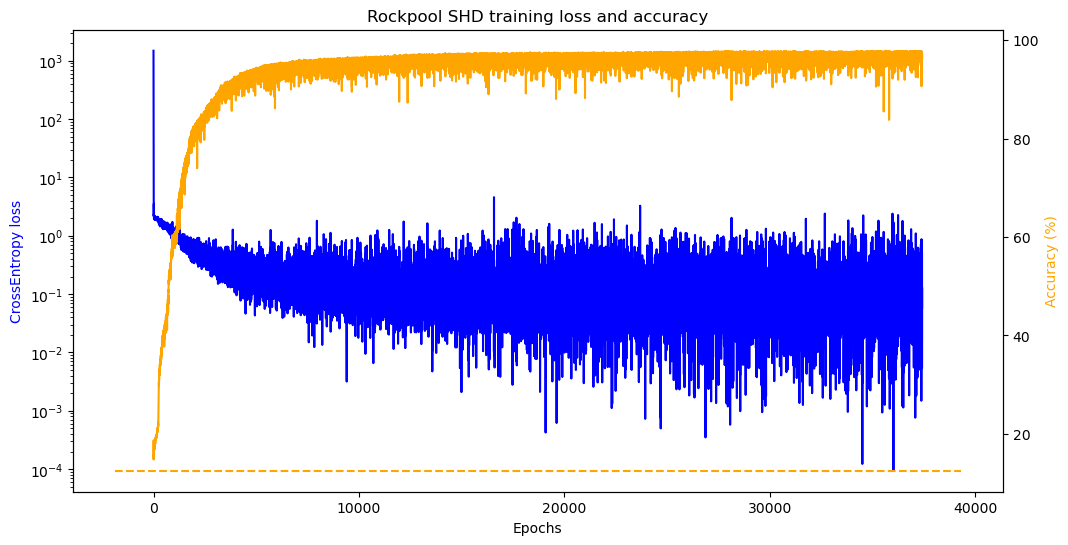

In [ ]:
Image('loss-pretrained-37ke.png')

In [ ]:
events, label = train_data[2]
out, _, rd = net(events, record = True)

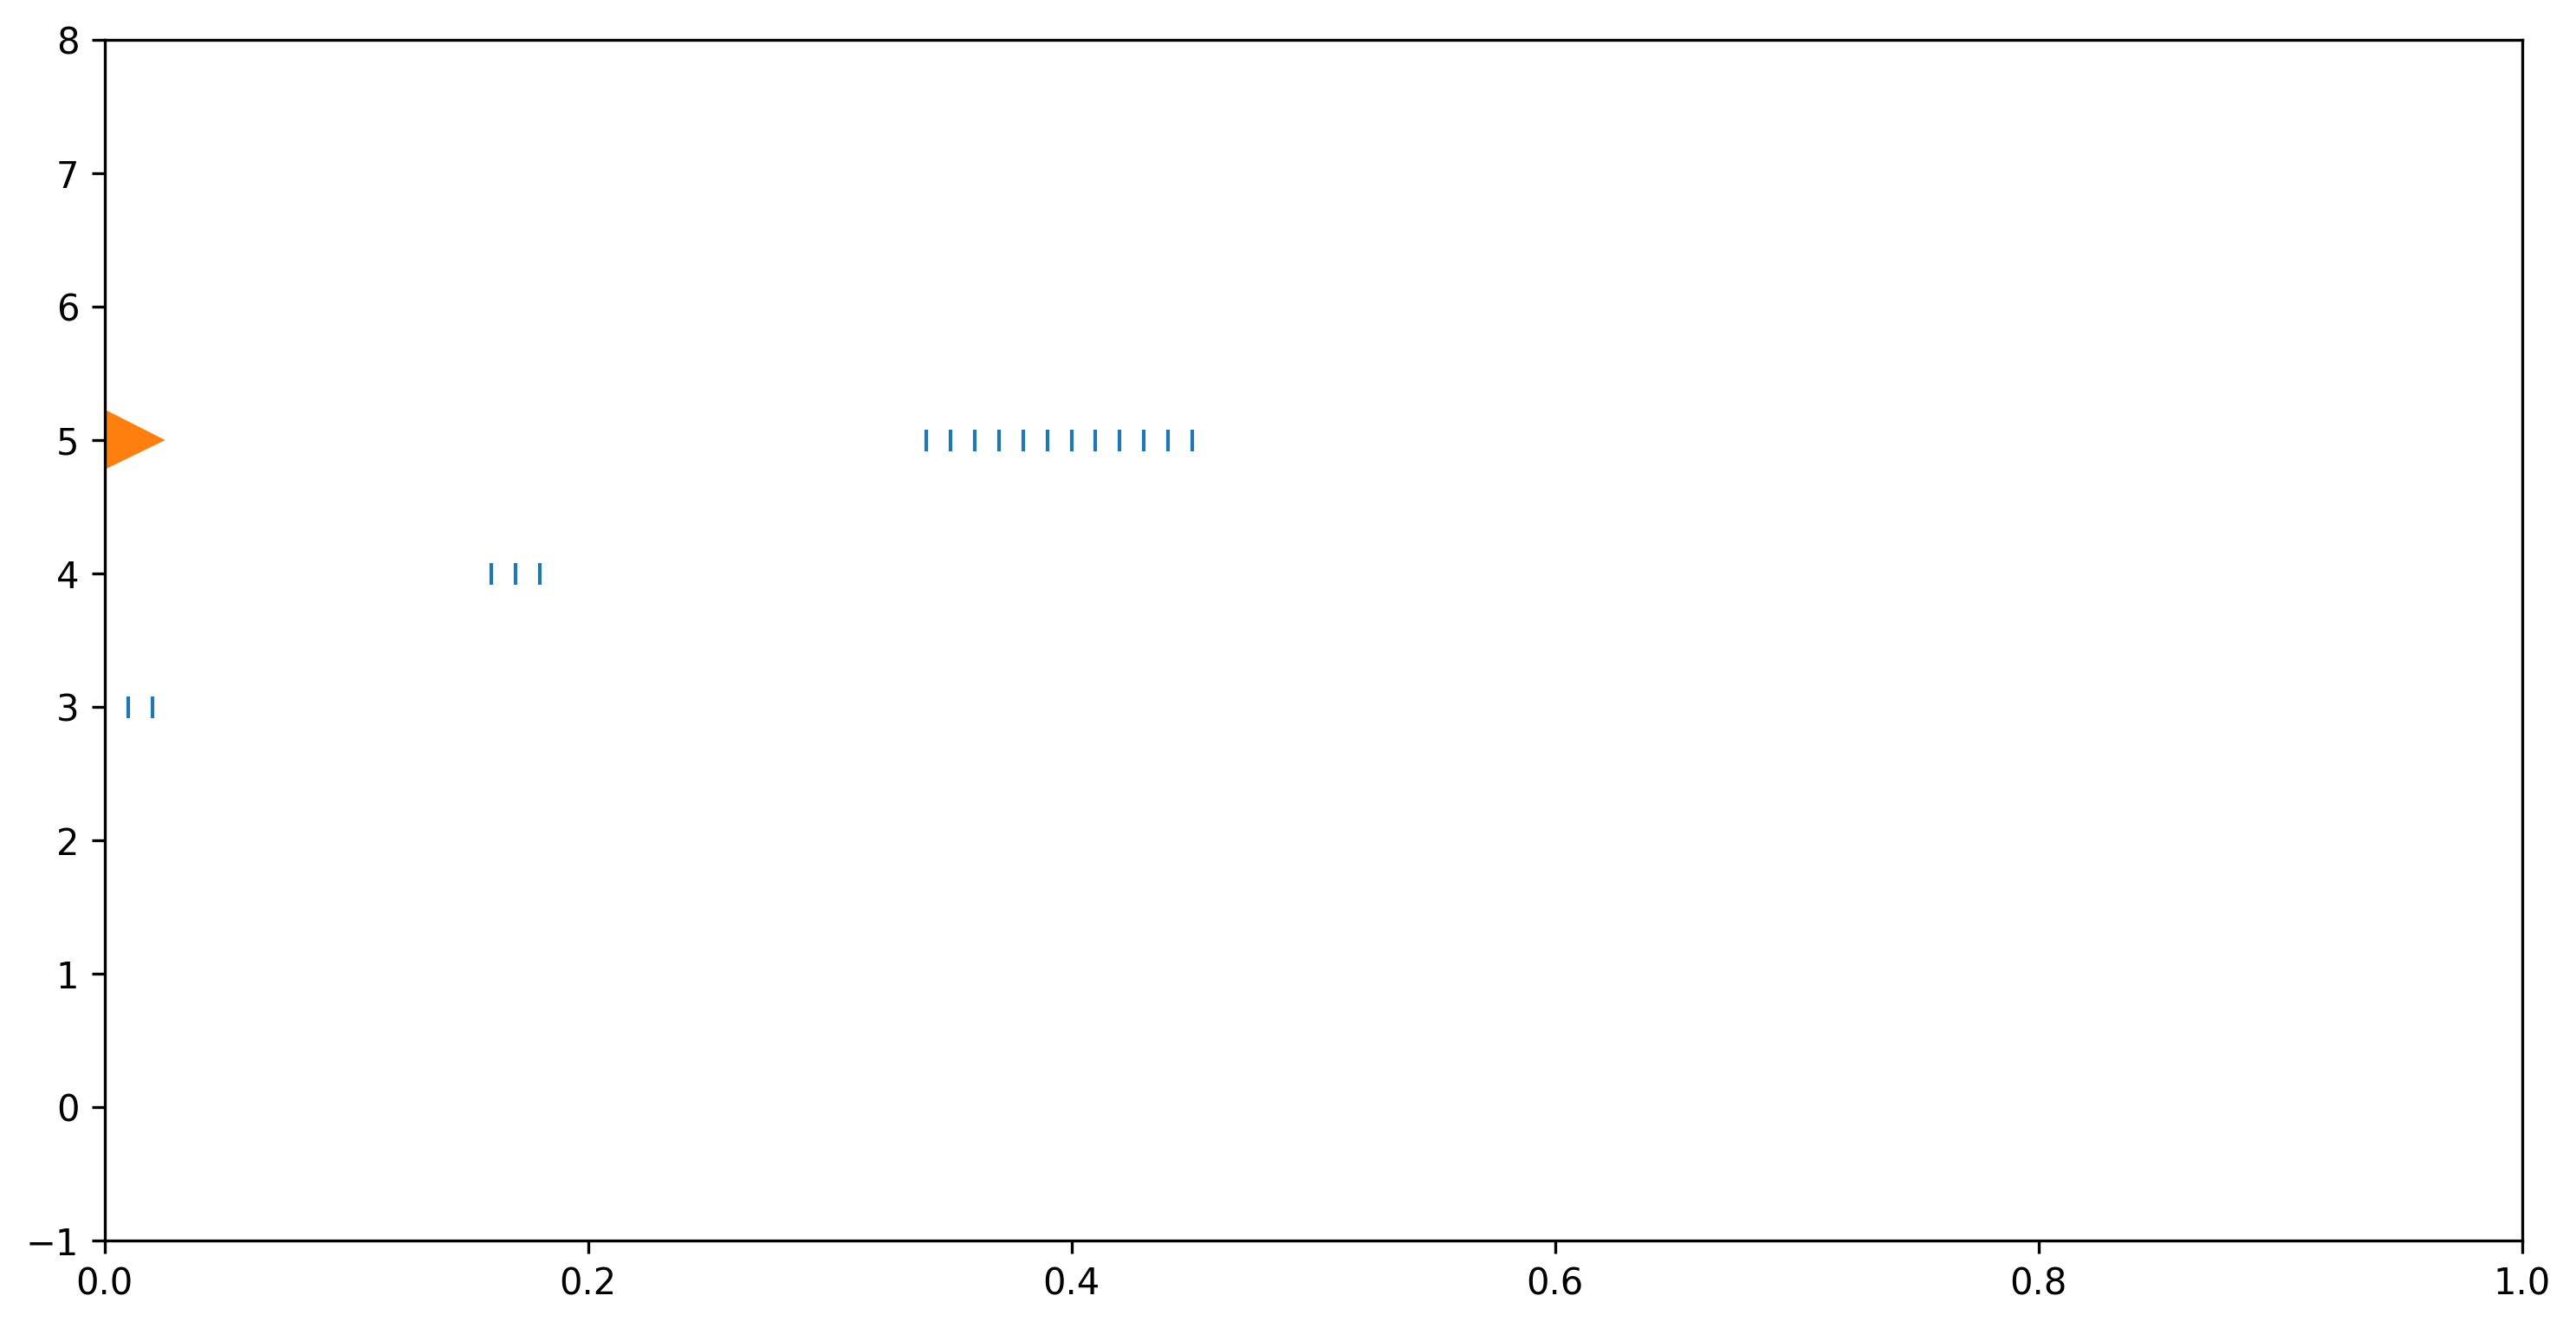

In [ ]:
times, channels = torch.where(out[0])
plt.plot(times * net_dt, channels, '|')
# plt.plot(rd['4_LIFTorch']['vmem'][0].T.detach())
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-1, 8])
plt.xlim([0, 1.]);

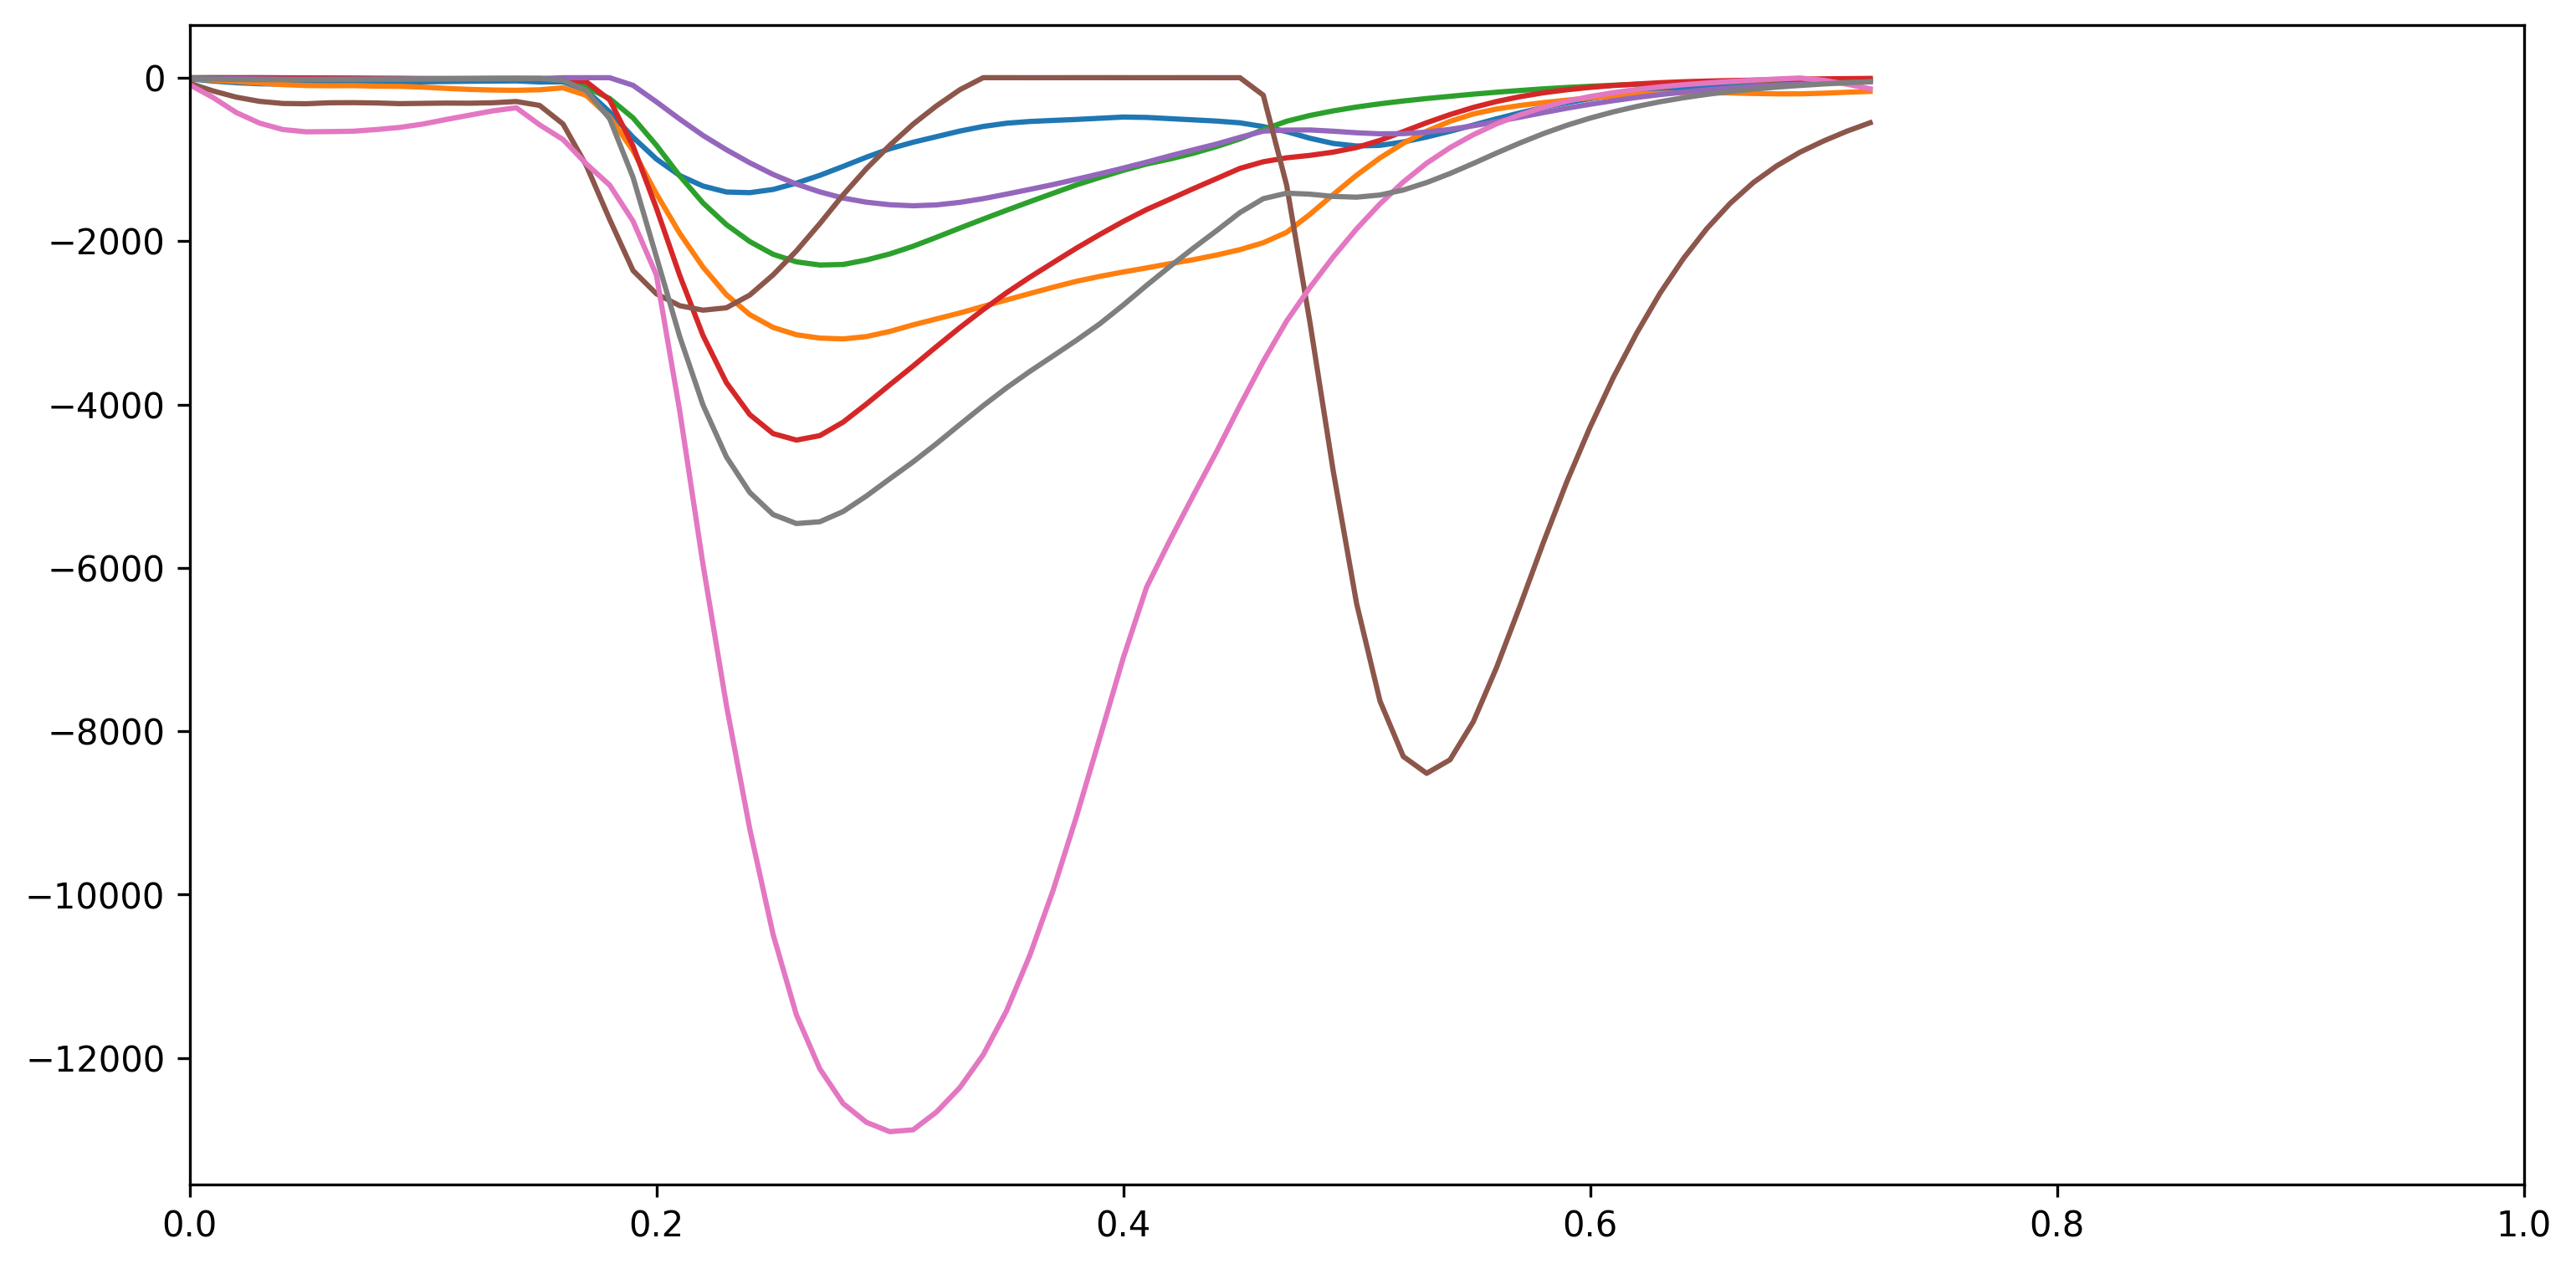

In [ ]:
times = np.arange(out.shape[1]) * net_dt
plt.plot(times, rd['4_LIFTorch']['vmem'][0].detach())
plt.xlim([0, 1.]);

# BACK TO POWERPOINT to describe Xylo architecture

In [ ]:
# - Extract a serialised computational graph from the network
net.as_graph()

GraphHolder "TorchSequential__11685652624" with 16 input nodes -> 8 output nodes

In [ ]:
# - Now we need to map and quantise
import rockpool.devices.xylo.syns61201 as xylo

spec = xylo.mapper(net.as_graph())
print(spec.keys())

dict_keys(['mapped_graph', 'weights_in', 'weights_out', 'weights_rec', 'dash_mem', 'dash_mem_out', 'dash_syn', 
'dash_syn_2', 'dash_syn_out', 'threshold', 'threshold_out', 'bias', 'bias_out', 'weight_shift_in', 
'weight_shift_rec', 'weight_shift_out', 'aliases', 'dt'])

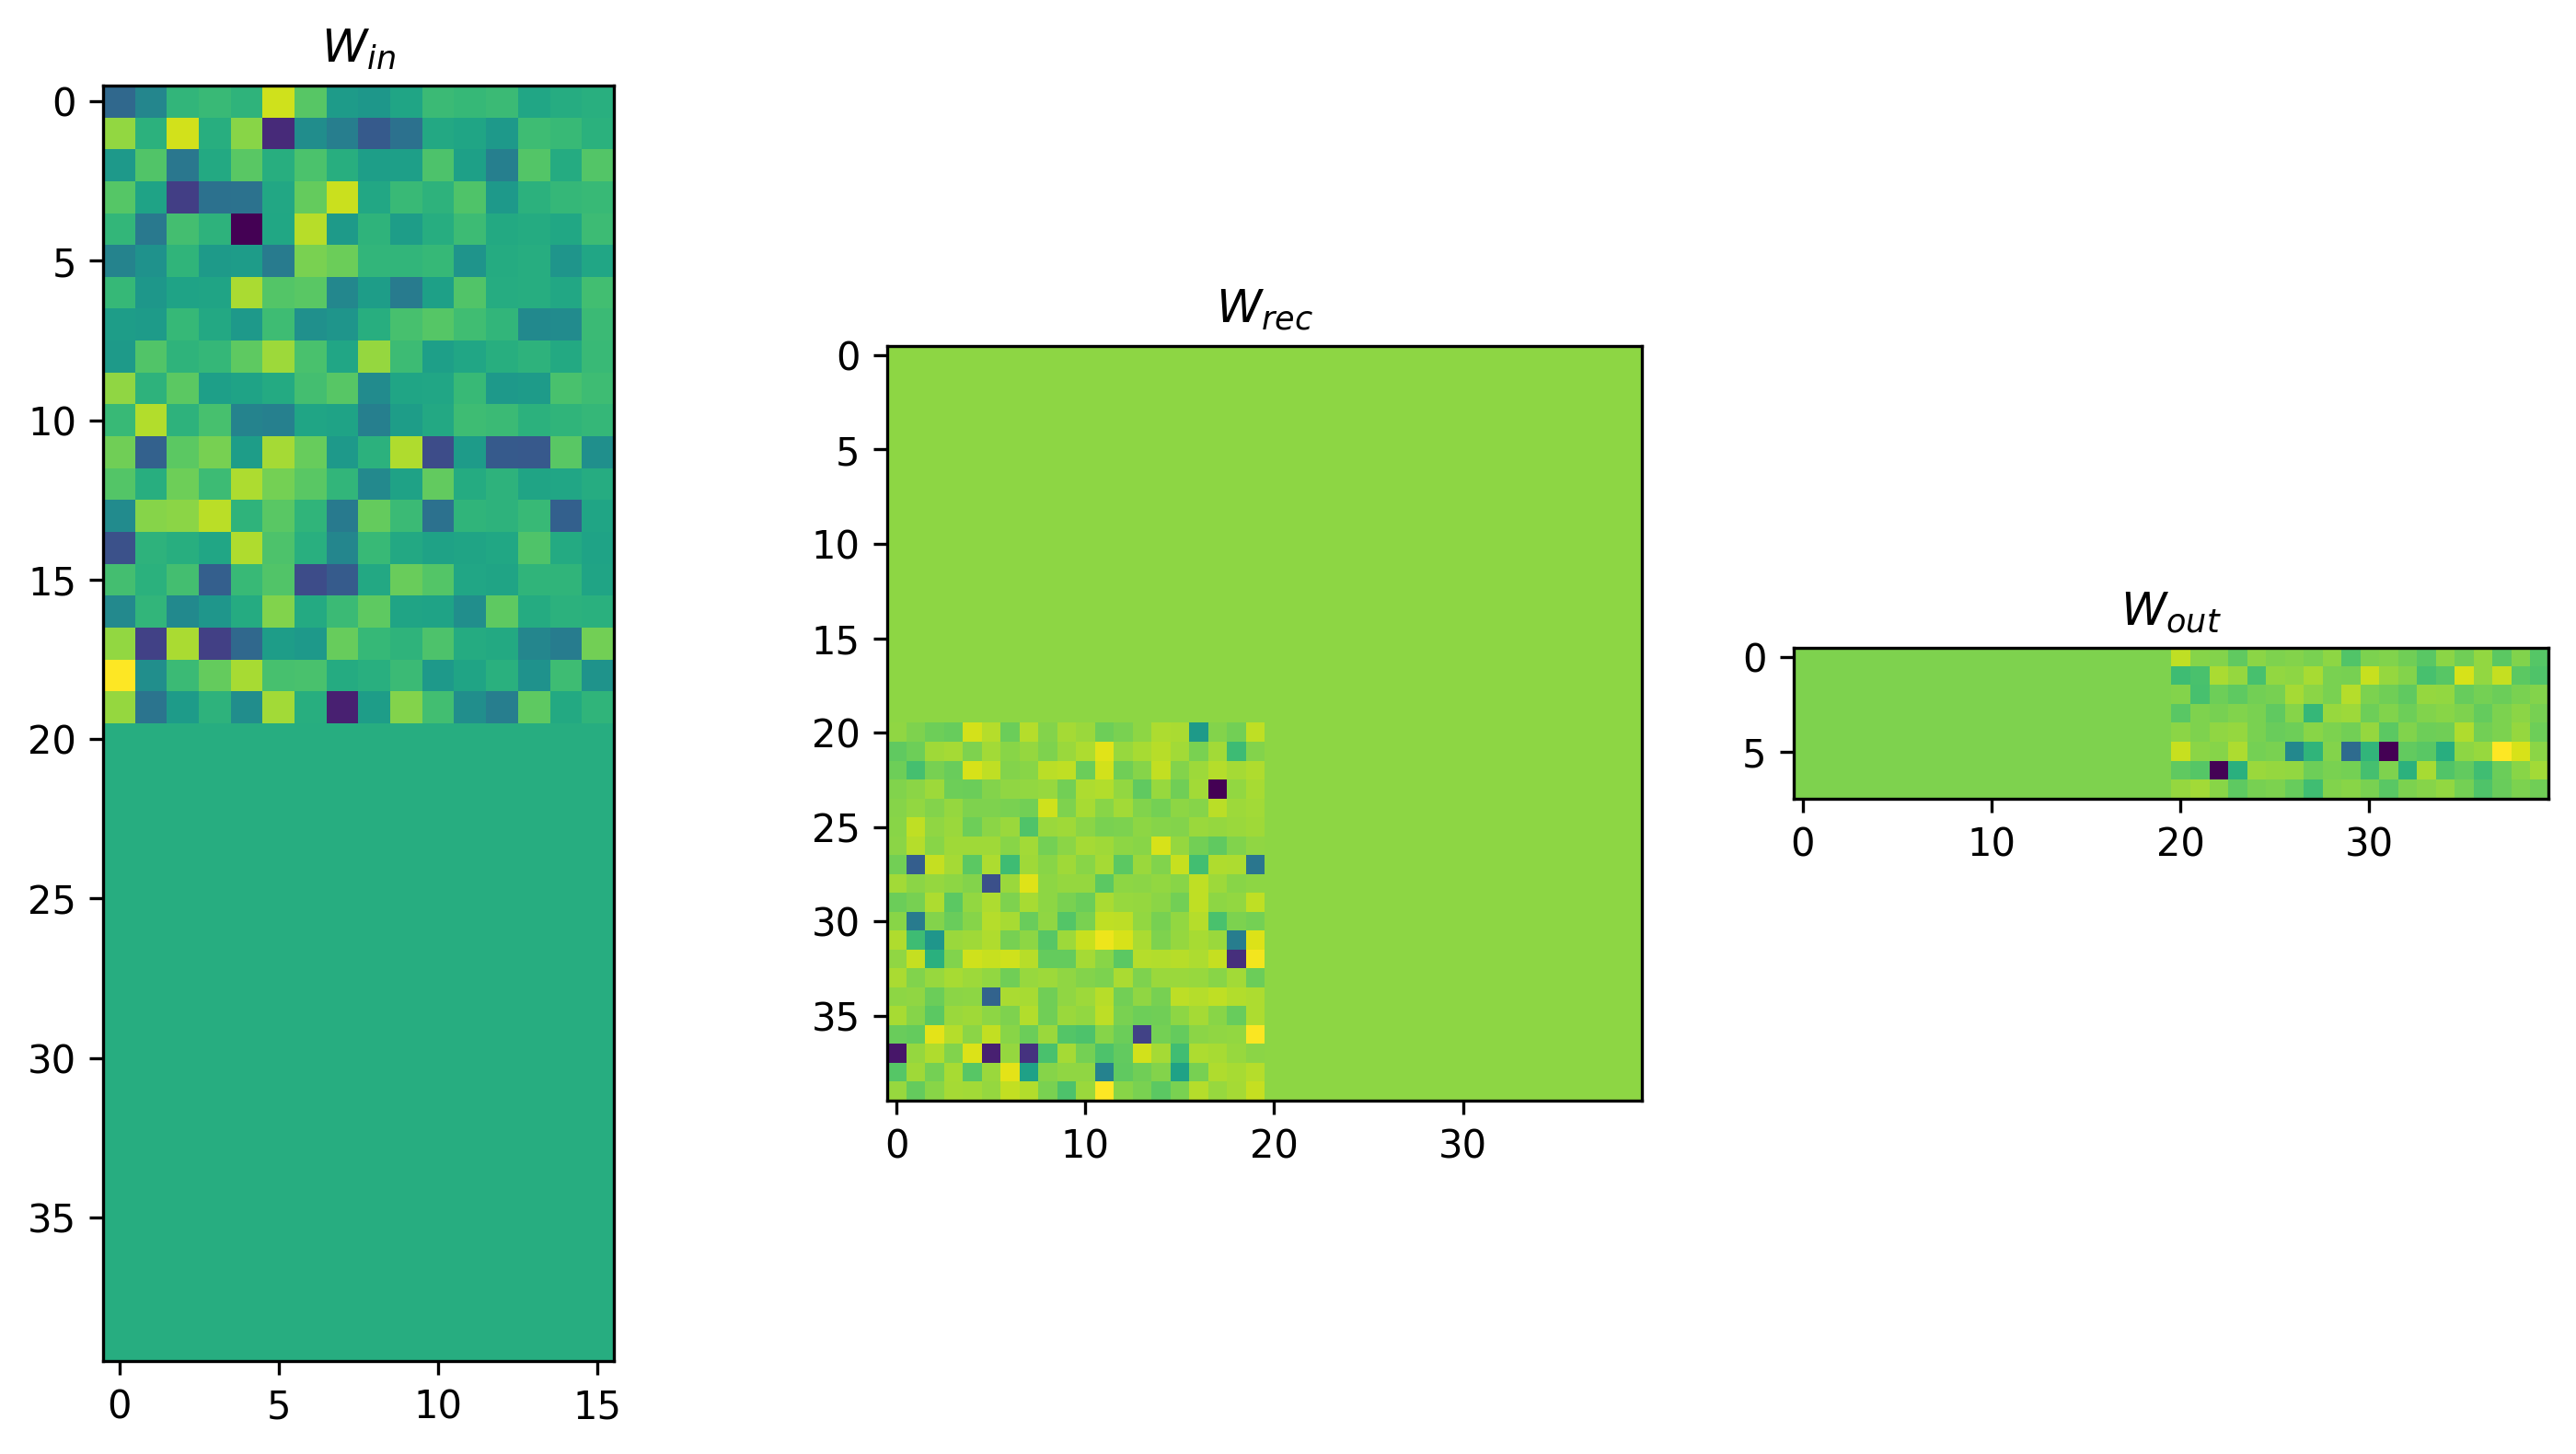

In [ ]:
# - Let's look at the mapped weights
plt.subplot(1, 3, 1)
plt.imshow(spec['weights_in'].T)
plt.title('$W_{in}$')

plt.subplot(1, 3, 2)
plt.imshow(spec['weights_rec'].T)
plt.title('$W_{rec}$')

plt.subplot(1, 3, 3)
plt.imshow(spec['weights_out'].T)
plt.title('$W_{out}$');

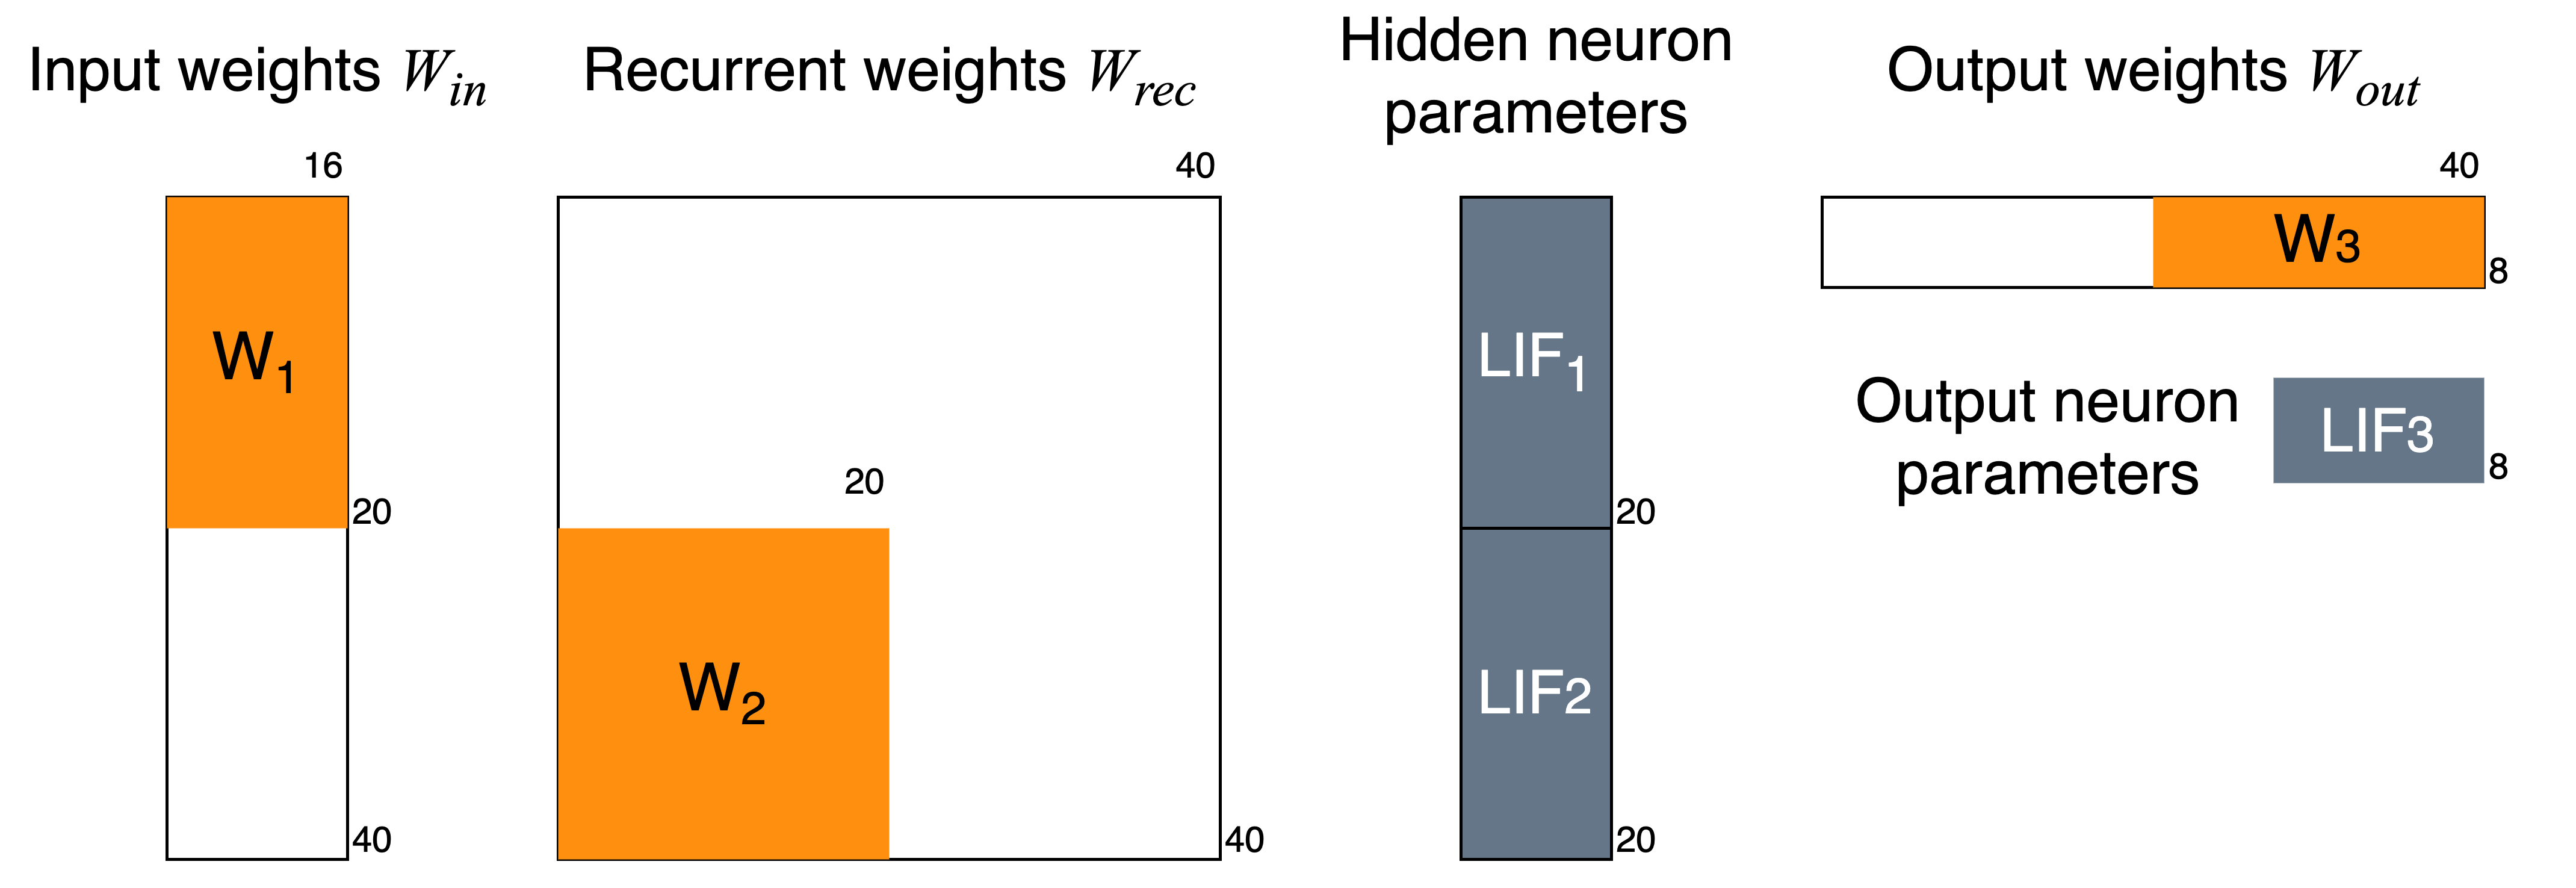

In [ ]:
Image('images/mapped-weights.svg.png')

In [ ]:
# - Perform quatization
from rockpool.transform.quantize_methods import channel_quantize, global_quantize

spec_Q = spec
spec_Q.update(channel_quantize(**spec))

In [ ]:
# - Convert to a HW configuration bitstream
config, is_valid, _ = xylo.config_from_specification(**spec_Q)
print(config)

xyloCore2::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, synapse2_enable=0, bias_enable=1, 
direct_fetch_state_ram=0, enable_hibernation_mode=0, clear_network_state=0, time_resolution_wrap=0, 
hibernation_mode_time_resolution_wrap=0, input=xyloCore2::configuration::InputConfig(weight_bit_shift=0, weights={ 
-118 54 -45 32 8 -108 23 -57 -44 127 25 52 55 -56 -127 26 -104 63 127 52 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
-67 5 59 -12 -44 -69 -47 -64 58 14 127 -102 1 78 7 5 22 -126 -43 -57 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 78 
-127 -127 16 19 -23 40 15 76 11 40 79 81 2 25 -99 73 20 -17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 23 1 -9 -72 5 
-48 -20 -17 24 -35 42 56 31 110 -11 -104 -67 -127 48 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 50 67 -71 -127 
-42 127 -70 70 -26 -87 -22 127 11 87 17 -5 -83 83 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 127 -127 3 -6 -5 -127
56 56 127 -7 -91 78 84 48 33 35 127 -19 28 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 -34 52 41 55 108 62 -103 
49 46 -18 47 60 12 2 -127 -8 -24 30 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -30 -49 2 85 -16 94 -81 -86 -17 71 
-22 -28 18 -84 -56 -109 39 43 -3 -127 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -38 -86 -35 -7 6 23 -34 5 120 -86 -93
6 -77 56 17 -6 85 13 3 -16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -15 -63 -34 16 -13 21 -104 72 34 -21 -33 84 -23 
24 -6 47 -25 8 19 46 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -5 54 6 0 29 -27 96 -33 -19 -9 -127 69 -100 -16 36 
-30 29 -29 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 19 -8 -30 29 13 -65 54 59 -18 30 32 -24 -4 13 -14 -10 -88 -3 
-13 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -21 -107 -24 -3 -4 -1 29 2 -49 28 -111 11 9 -10 -13 87 -4 4 -47 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -12 17 61 6 -2 0 0 -127 13 -44 9 -112 -19 21 35 10 -5 -48 -38 30 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -2 12 -4 13 -5 -63 -11 -119 -8 54 16 39 -17 -127 -4 9 13 -60 23 -4 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 3 4 61 15 12 -20 37 51 30 39 20 -41 -2 -14 -15 -13 7 49 -37 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 }, syn2_weights={ 0 }), reservoir=xyloCore2::configuration::ReservoirConfig(weight_bit_shift=0, weights={ 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 -65 -52 -3 -16 -11 -9 -11 7 -84 -3 15 1 92 0 58 -12 -127 -31 12 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -11 -47 -127 -1 10 88 68 -127 -1 -54 -127 -45 14 -48 1 -21 -14 1 9 -52 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 -24 23 -36 3 -22 1 -9 19 2 68 -5 -95 -36 31 -14 -127 25 8 -13 -6 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 -29 28 -60 -8 14 23 30 8 -1 -127 -18 6 -4 85 -1 26 11 -4 12 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 47 -21 106 -8 -32 -65 32 -19 -4 8 -4 8 18 47 -1 39 -1 19 -30 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 25 72 
-2 -31 -8 31 11 -127 67 18 15 16 16 -127 -4 16 -122 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -25 -7 -18 1 -43 21
-10 -33 4 -37 12 -12 18 -108 10 -35 -2 2 42 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 7 -9 1 -60 -127 36 6 25 
57 -19 0 11 29 10 80 -12 -113 -85 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -8 -22 64 2 127 23 -48 -2 -1 -1 1 -29 
-13 49 -12 -71 4 -19 -4 -24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 71 -7 -34 33 -5 6 2 -47 -30 7 -12 7 1 28 
-20 6 0 -84 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 39 -54 7 47 -5 41 -2 2 -87 -10 26 6 -36 6 11 -22 -7 1 12 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -23 108 99 8 -15 -40 [1;3

In [ ]:
# - Create an HDK simulator module from the bitstream
mod = xylo.XyloSim.from_config(config, dt = net_dt)
print(mod)

XyloSim  with shape (16, 1000, 8)

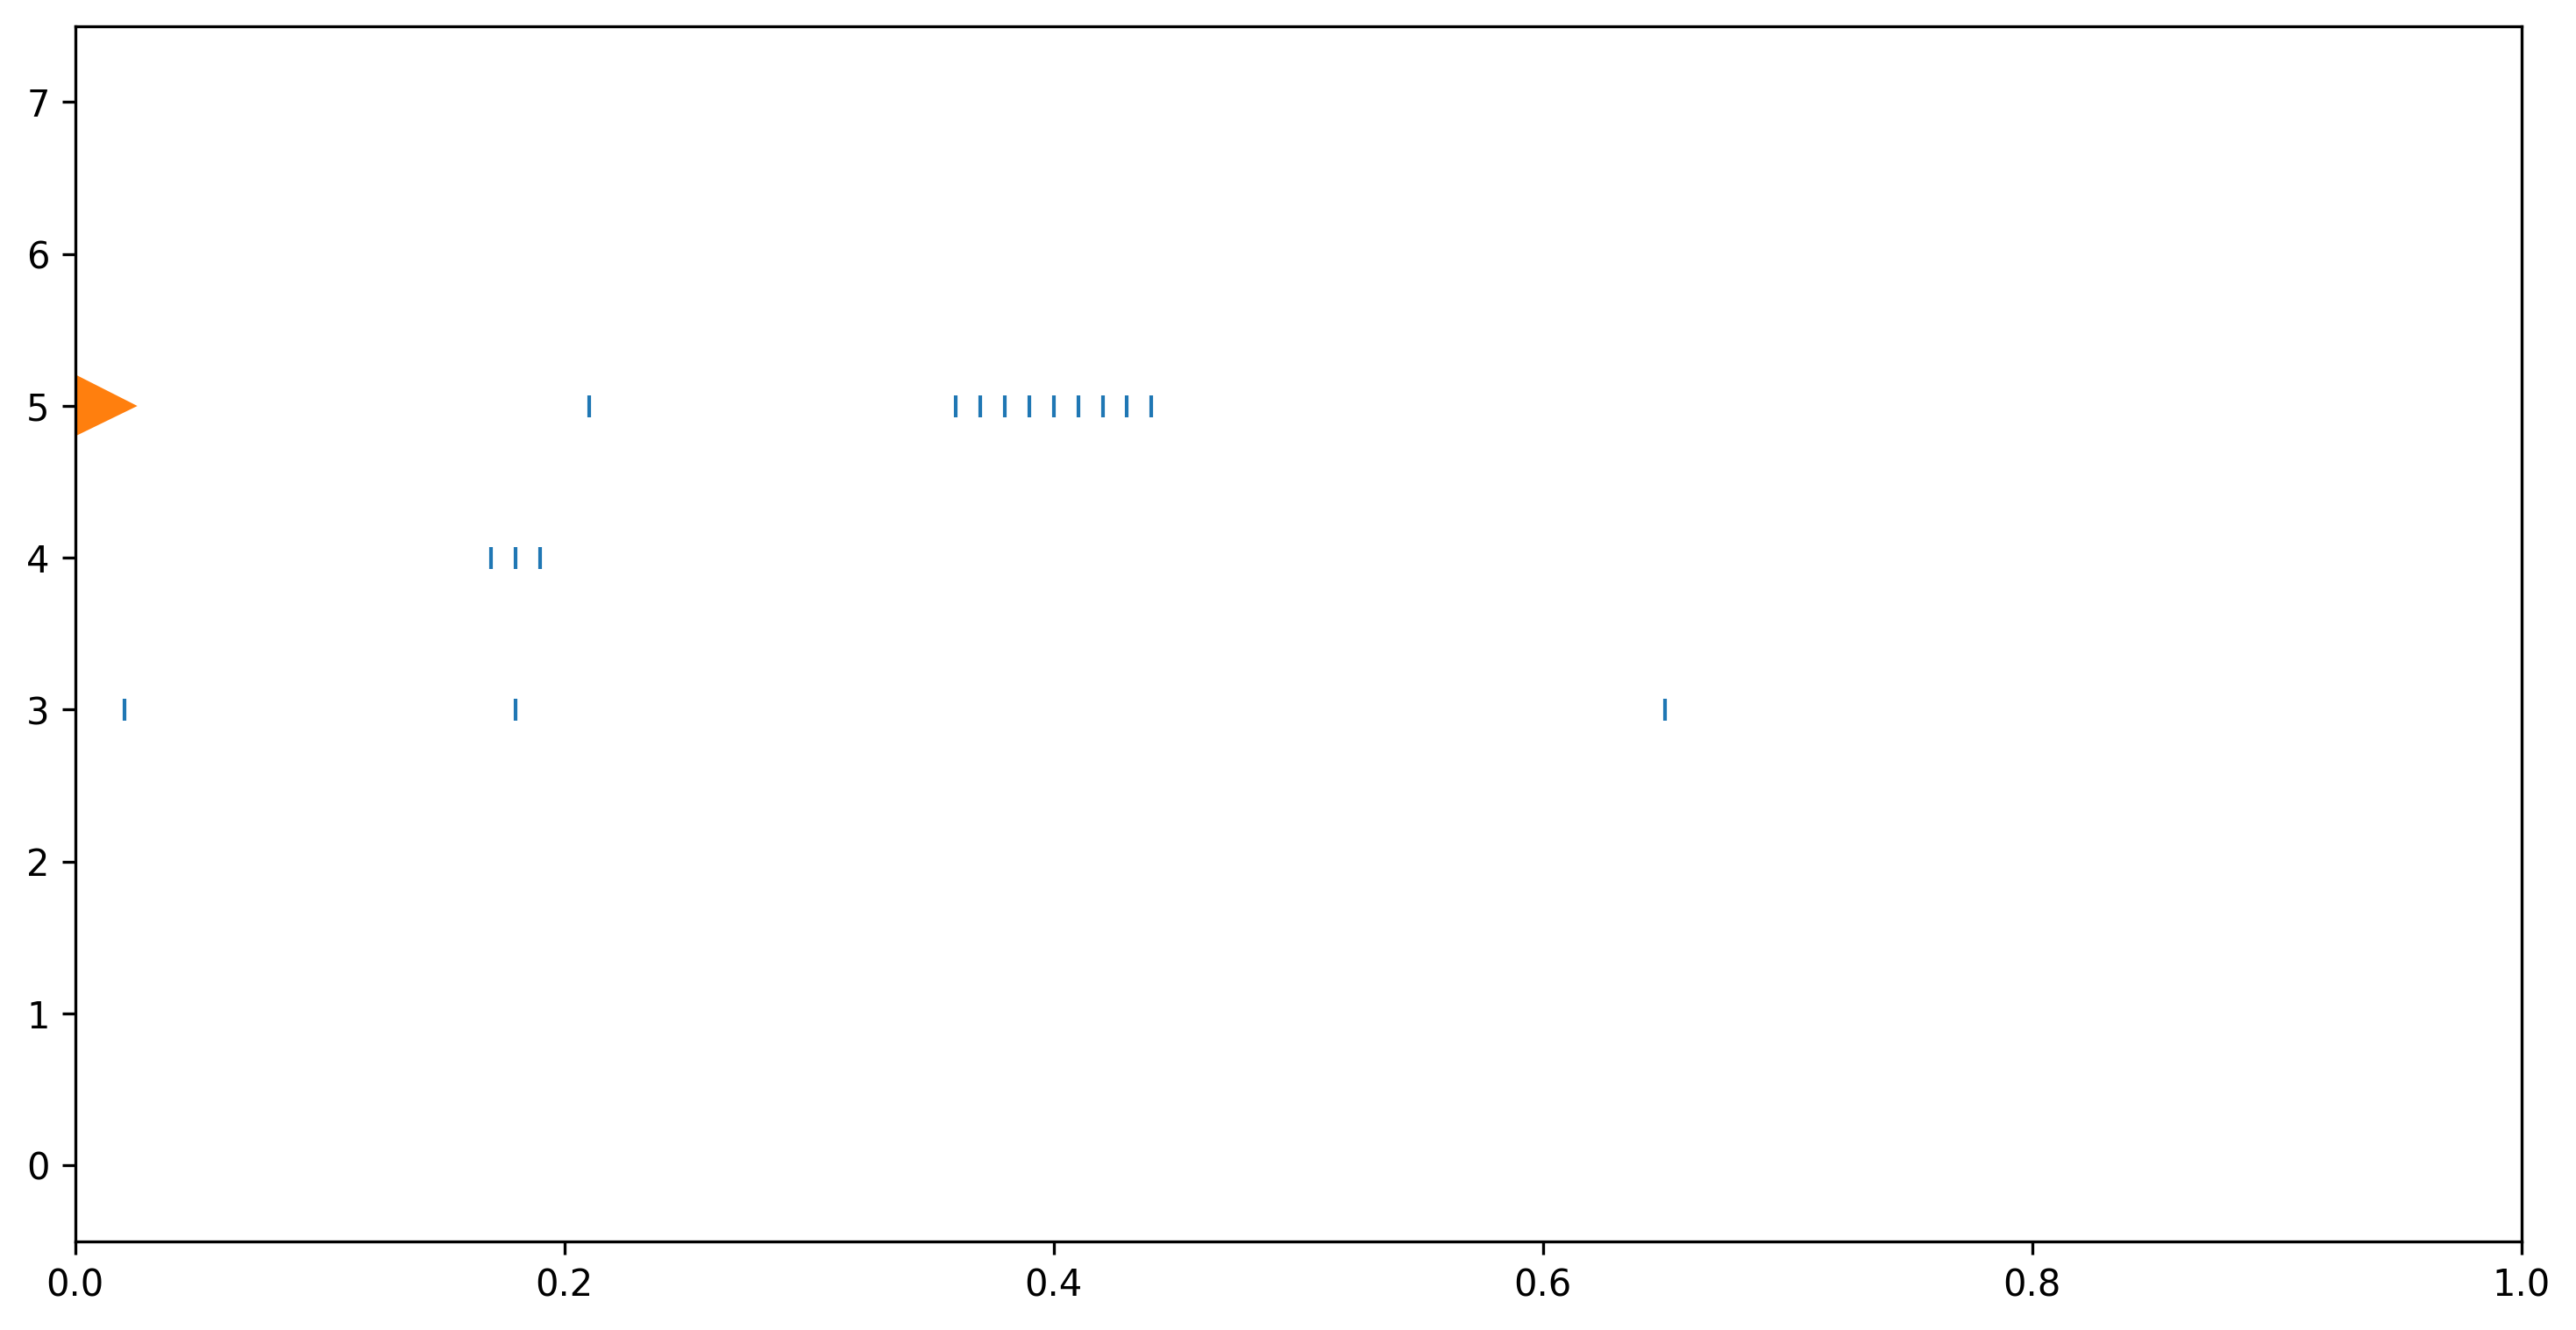

In [ ]:
# - Let's look at the output of the simulated HDK on a training sample
events, label = train_data[2]
out_xsim, _, rd_xsim = mod(events.numpy(), record = True)
times, channels = np.nonzero(out_xsim)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

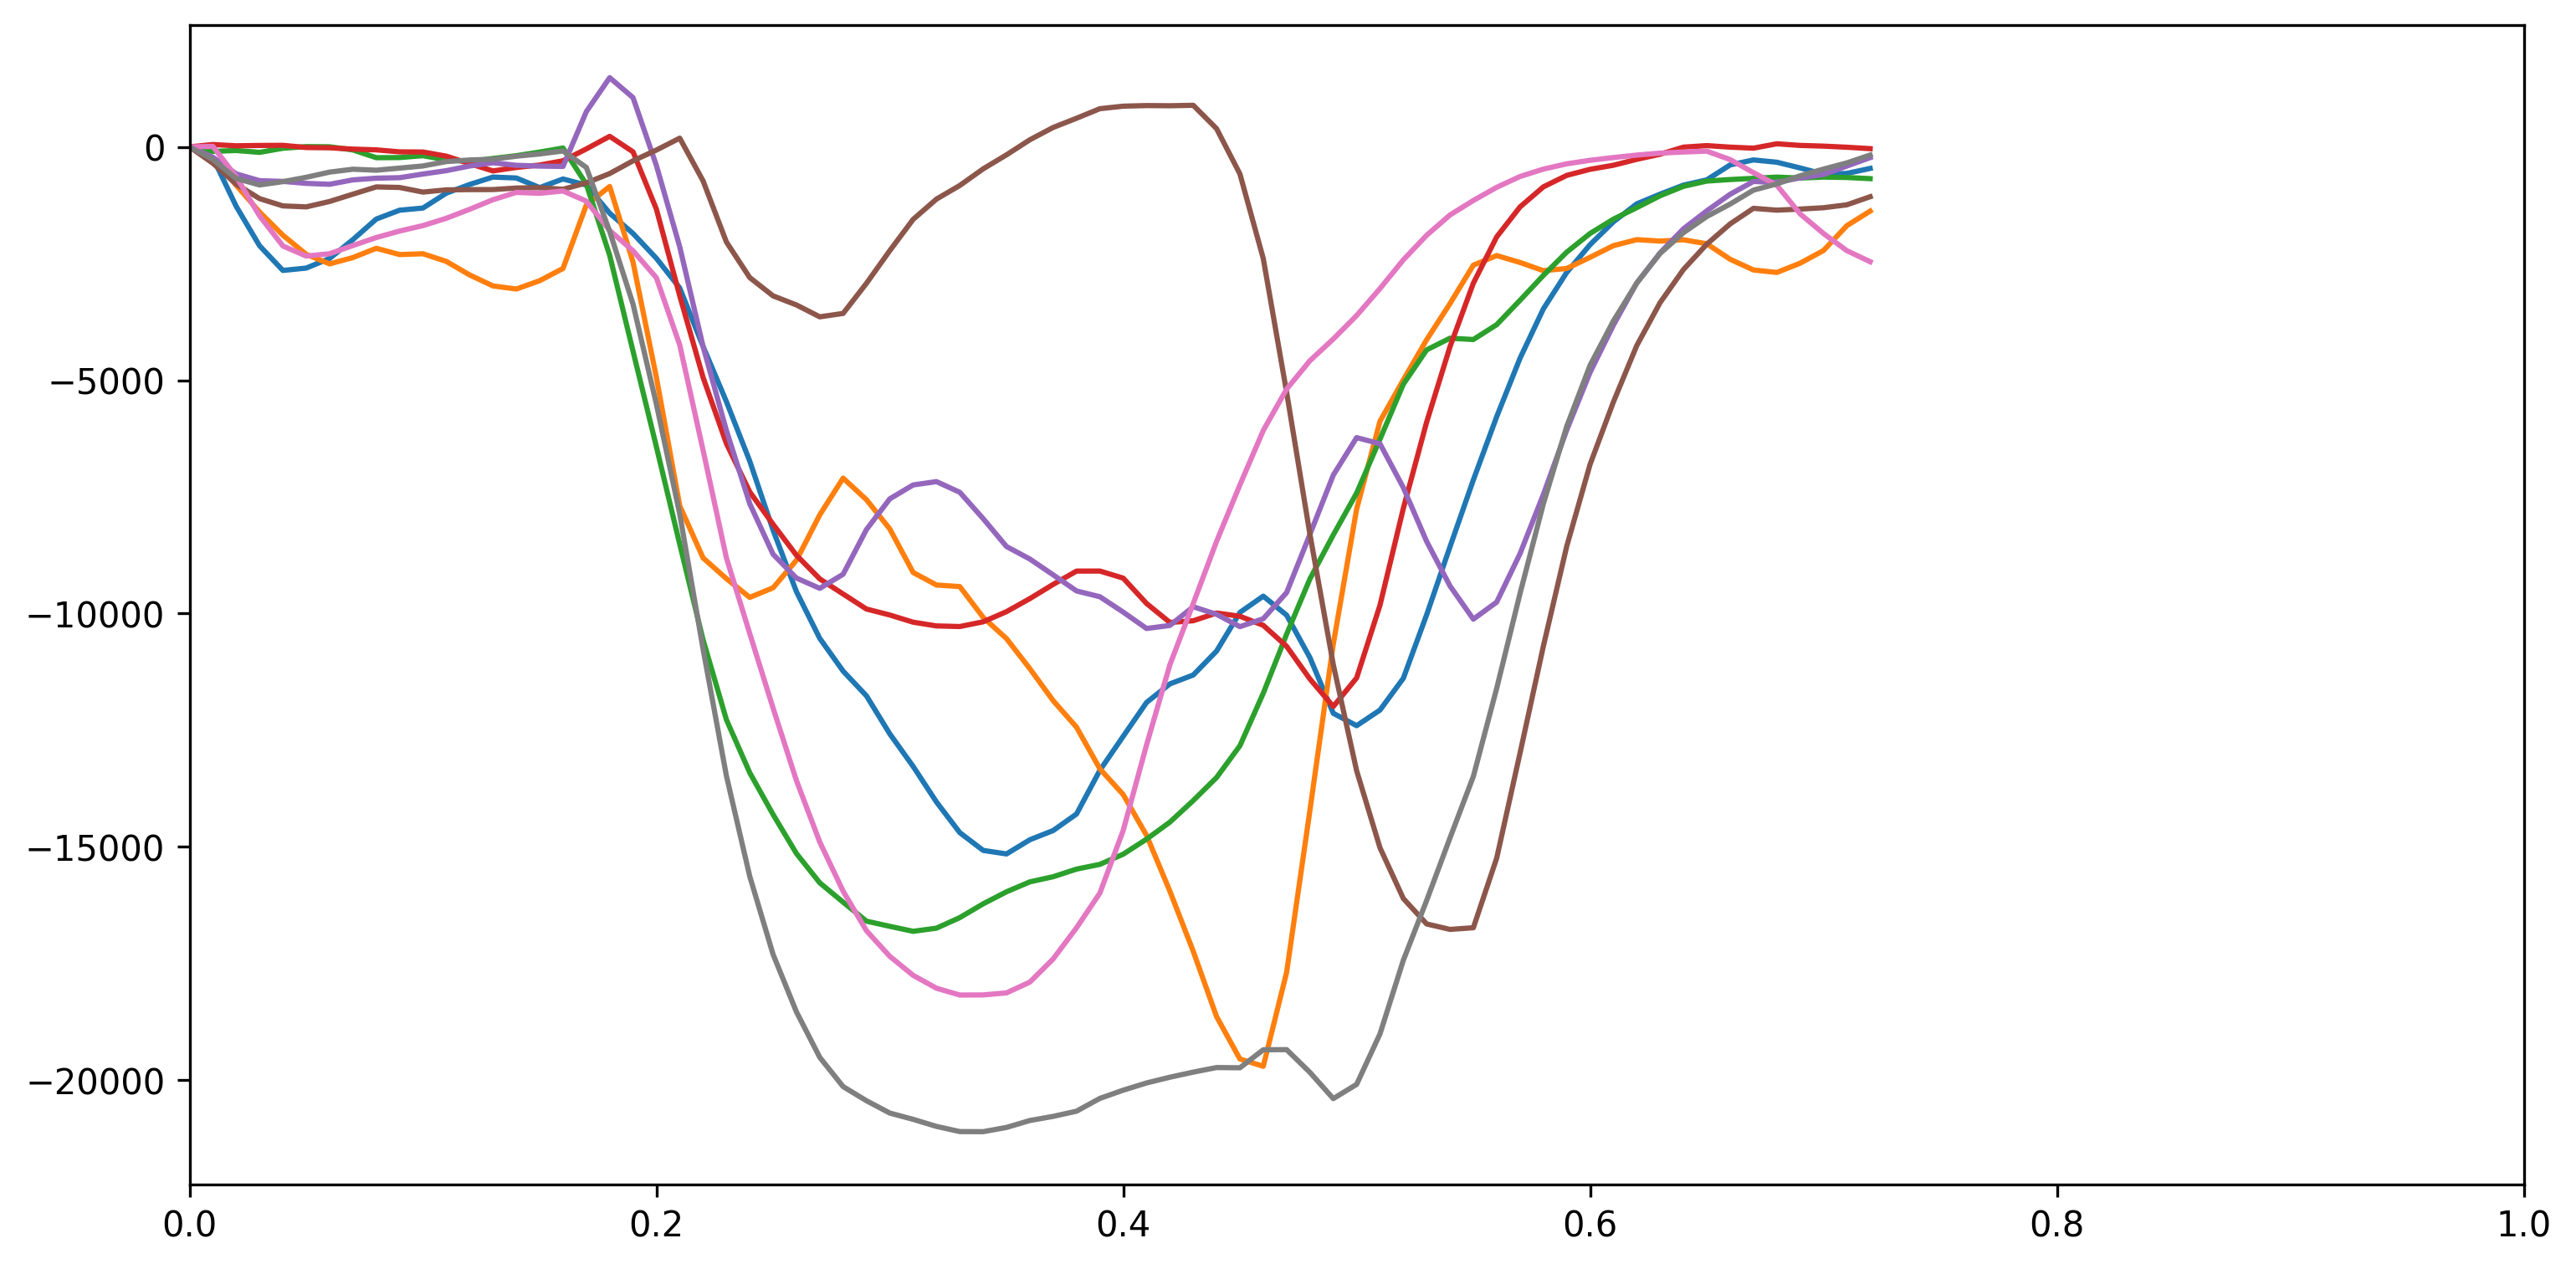

In [ ]:
times = np.arange(out_xsim.shape[0]) * net_dt
plt.plot(times, rd_xsim['Vmem_out'])
plt.xlim([0, 1.]);

In [ ]:
from rockpool.devices.xylo import find_xylo_hdks

In [ ]:
hdks, _, _ = find_xylo_hdks()
print(hdks)

The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x2dea20630>]

In [ ]:
hdk = hdks[0]

In [ ]:
mod_hdk = xylo.XyloSamna(hdk, config, net_dt)
print(mod_hdk)

XyloSamna  with shape (16, 40, 8)

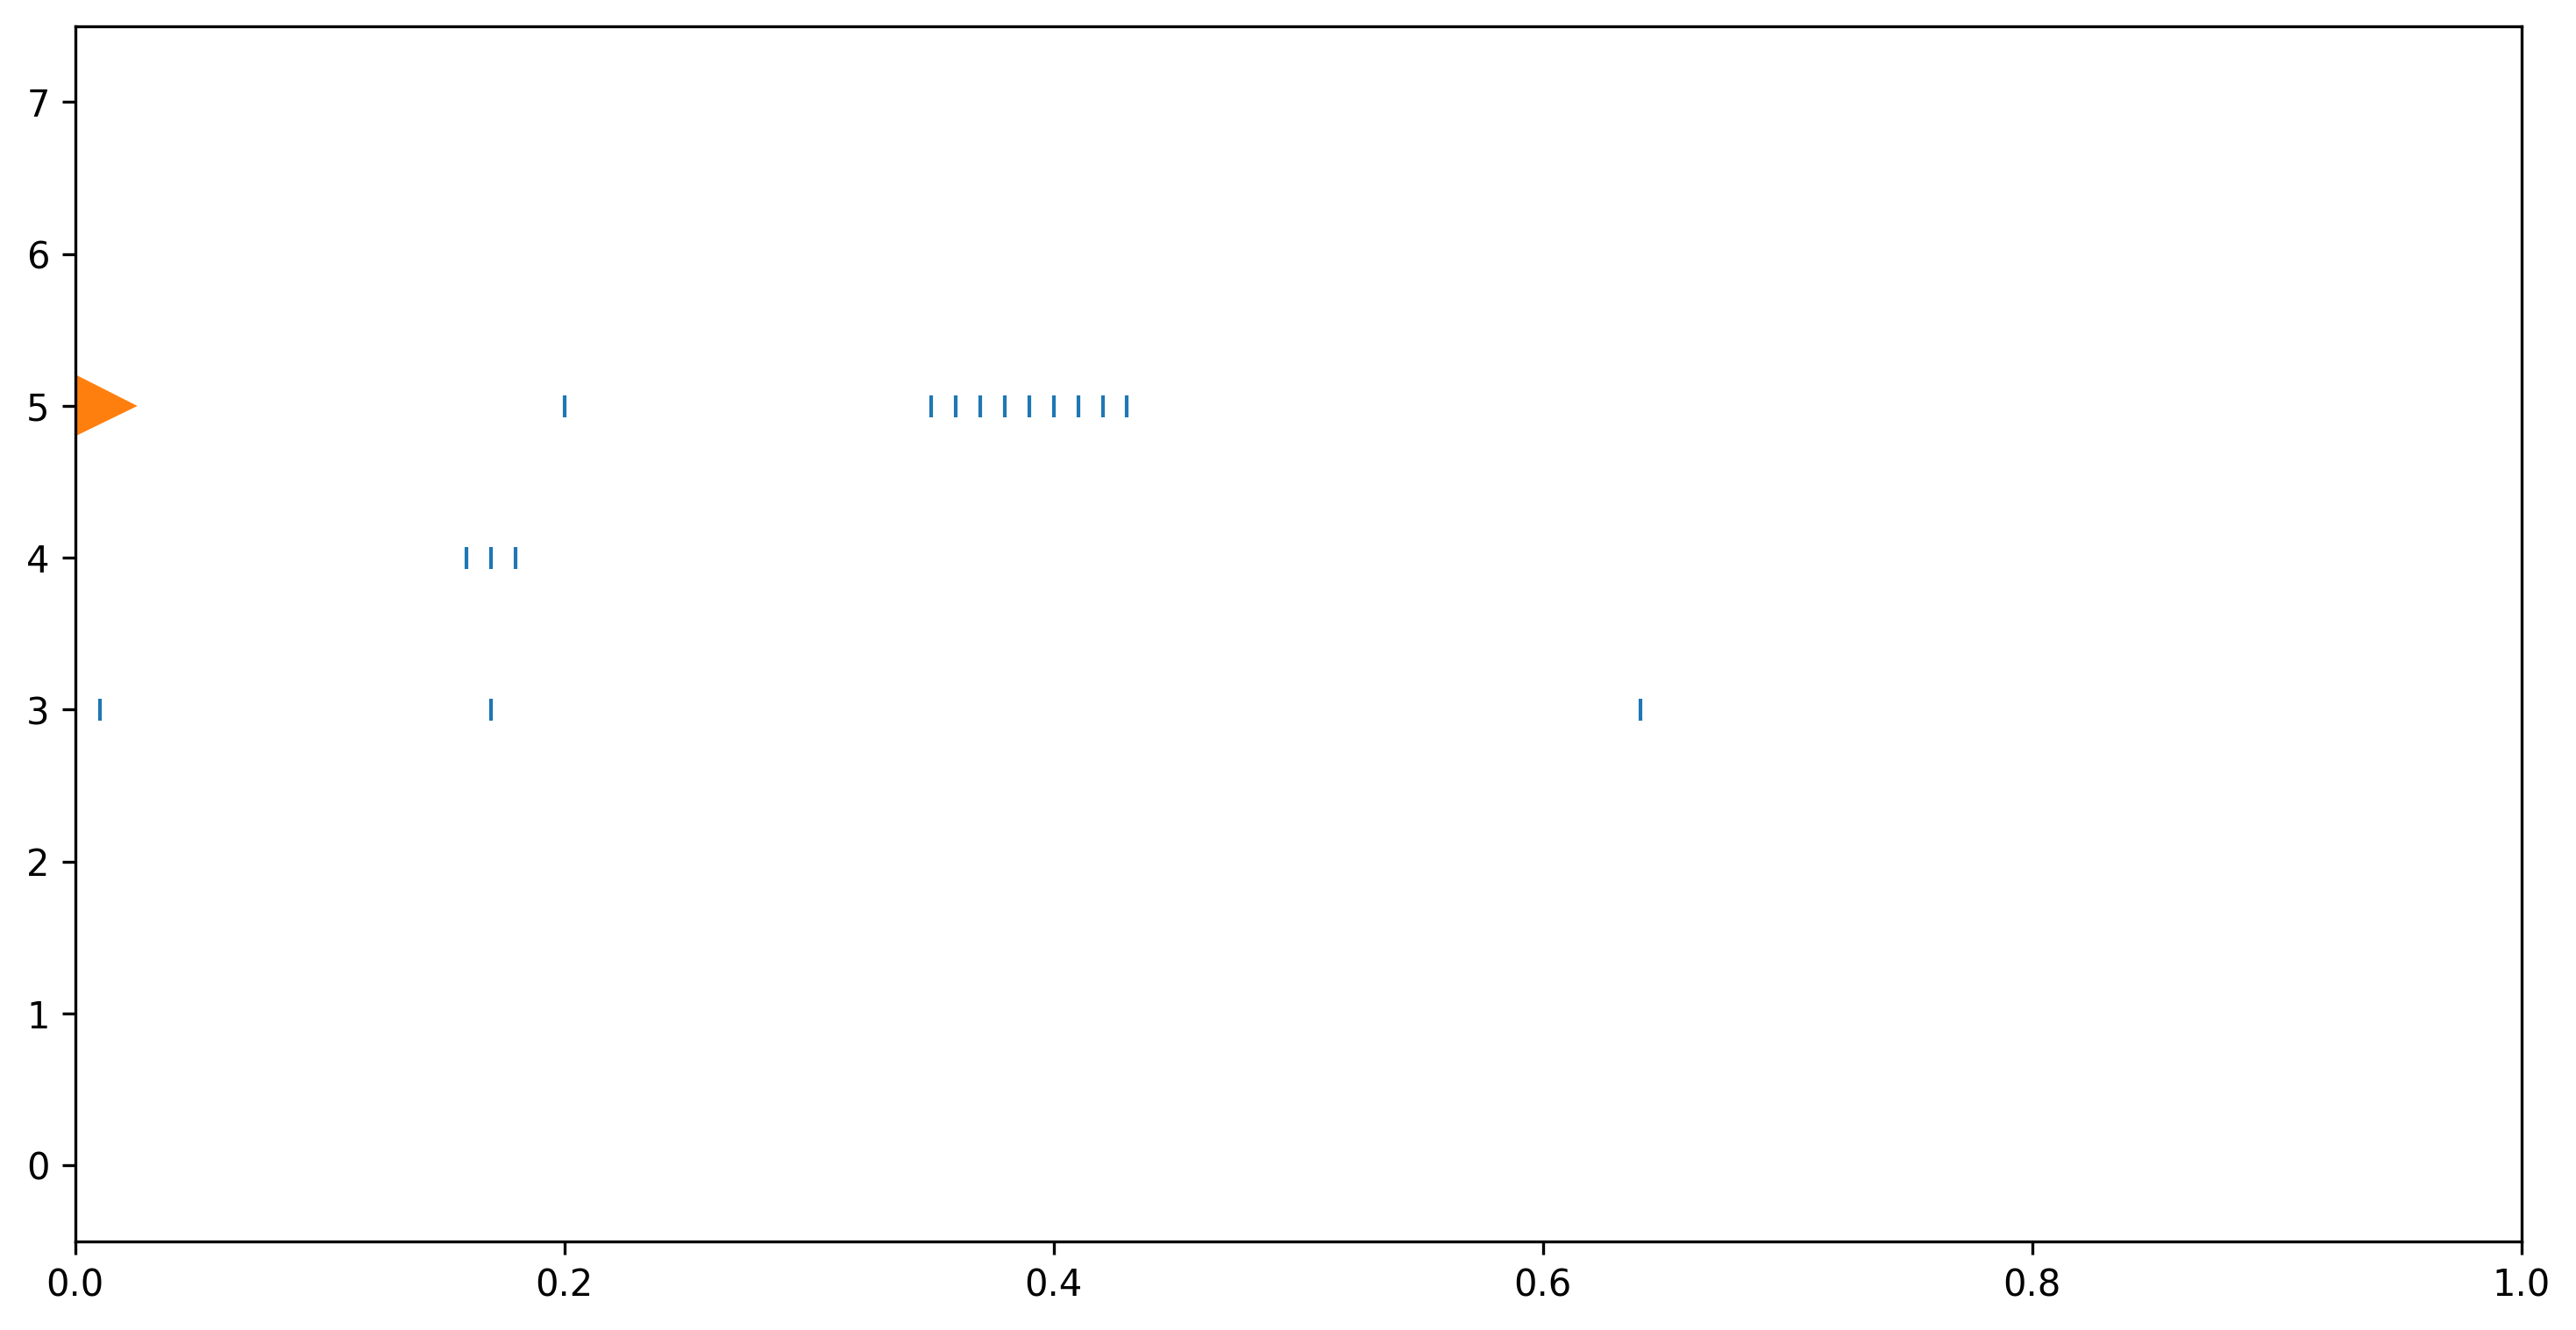

In [ ]:
events, label = train_data[2]
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True)
times, channels = np.nonzero(out_xhdk)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

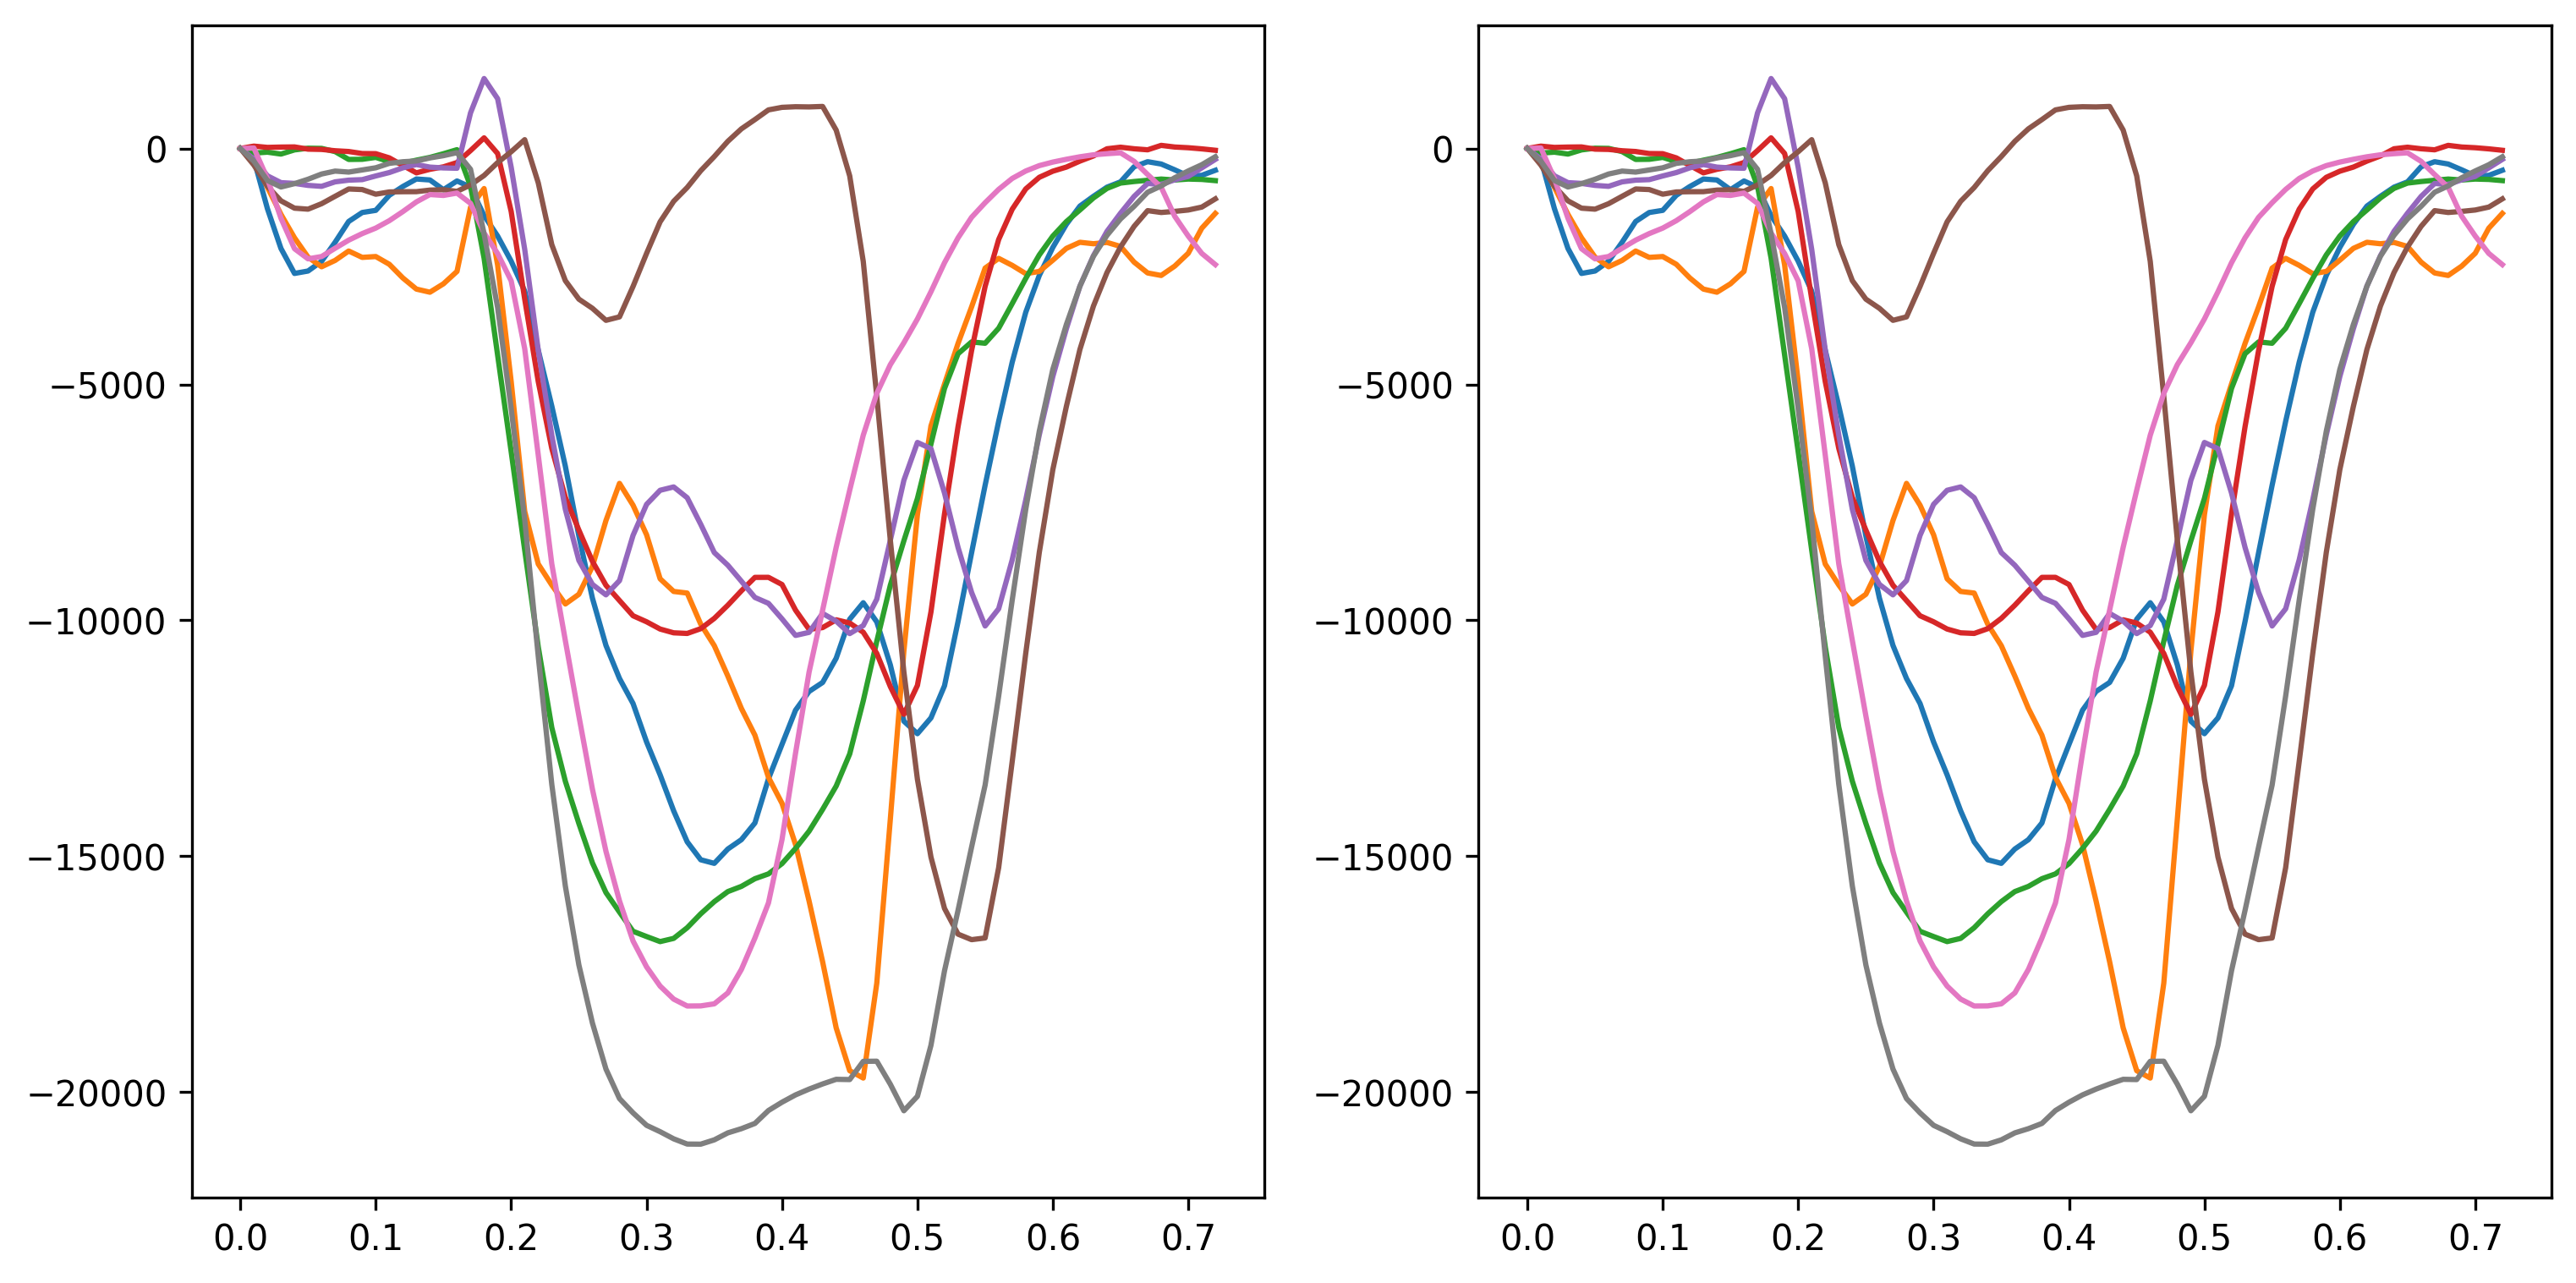

In [ ]:
times = np.arange(out_xhdk.shape[0]) * net_dt
plt.subplot(1, 2, 1)
plt.plot(times, rd_xhdk['Vmem_out'])
plt.subplot(1, 2, 2)
plt.plot(times, rd_xsim['Vmem_out']);

In [ ]:
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True, record_power = True)


print(f'Power measurement: {np.mean(rd_xhdk["io_power"]) * 1e6:.2f} muW')

Power measurement: 241.18 muW